# **Facial Expression Recognition Competition (30%)**
For this competition, we will use the a facial classification dataset. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

We provide baseline code that includes the following features:

*   Loding and Analysing the FER-2013 dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following changes could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 100) = acc_mark + efficiency mark + report mark  
###Acc_mark 20:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 20 marks. There will be a sliding scale applied in between.

###Efficiency mark 20:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 20 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 60:  
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [20 marks]

2. A description of how you have modified aspects of the system to improve performance. [20 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [10 marks]

4. Limitations/Conclusions: [10 marks]


In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Hasnain Hossain, Sadman Sharif
### Student ID: a1945656, a1944825
### Comptetion Name: Facial Expression Recognition/Classification
### Final Results:
### ACC: 70.4%       GFLOPs: 0.07465
##################################################################################################################################

## Cell 1 — Environment, Paths, Reproducibility

In [ ]:
# === Cell 01: Environment, paths, reproducibility ===
from collections import Counter
from PIL import Image, ImageOps
from pathlib import Path

import os, sys, math, random, shutil, warnings

import io
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings("ignore")

def in_colab() -> bool:
    return "google.colab" in sys.modules

if in_colab():
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        print("[Env] Google Drive mounted.")
    except Exception as e:
        print(f"[Env][WARN] Drive mount failed: {e}")

# Root dirs (local)
PROJECT_ROOT  = Path("./project"); PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
DATA_ROOT     = Path("./data");    DATA_ROOT.mkdir(parents=True, exist_ok=True)
CKPT_DIR      = PROJECT_ROOT / "checkpoints"; CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR       = PROJECT_ROOT / "logs";        LOG_DIR.mkdir(parents=True, exist_ok=True)

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Optional strict determinism (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Env] torch={torch.__version__}, torchvision={torchvision.__version__}, device={device}")

# Data path (edit if needed)
FER_CSV_PATH = Path("/content/drive/MyDrive/fer2013.csv") if in_colab() else Path("./fer2013.csv")
print(f"[Env] CSV path → {FER_CSV_PATH}")


Mounted at /content/drive
[Env] Google Drive mounted.
[Env] torch=2.8.0+cu126, torchvision=0.23.0+cu126, device=cuda
[Env] CSV path → /content/drive/MyDrive/fer2013.csv


## Cell 2 — Global Config

 Ensuring a single source of truth

### Tuned Global Configuration

| **Category**      | **Key**               | **Value (Default in this cell)** | **Description** |
|-------------------|-----------------------|----------------------------------|-----------------|
| **I/O**           | `FER_CSV_PATH`        | `./fer2013.csv`                  | Path to FER2013 dataset (CSV). |
|                   | `SAVE_BEST_PATH`      | `./project/checkpoints/best_fer.pth` | Filepath to save best model checkpoint. |
| **Data**          | `IMG_SIZE`            | `96`                             | Input image size (HxW). |
|                   | `BATCH_SIZE`          | `300`                            | Training batch size. |
|                   | `NUM_WORKERS`         | `max(2, cpu_count - 2)`          | DataLoader workers for parallelism. |
| **Compute**       | `USE_AMP`             | Auto (True if CUDA/MPS available) | Enables Automatic Mixed Precision (AMP). |
| **Augmentation**  | `USE_AUG`             | `True`                           | Apply standard augmentations. |
|                   | `USE_AUG_ADV`         | `True`                           | Use advanced FER augmentation policy. |
|                   | `USE_MIXUP`           | `True`                           | Enable MixUp augmentation. |
|                   | `USE_CUTMIX`          | `True`                           | Enable CutMix augmentation. |
|                   | `USE_EMA`             | `True`                           | Track EMA weights during training. |
|                   | `USE_TTA`             | `True`                           | Use Test-Time Augmentation (test only). |
| **Late-phase**    | `AUG_CAP_LATE`        | `True`                           | Cap augmentation strength in later epochs. |
|                   | `TAPER_MIX_LATE`      | `True`                           | Gradually reduce MixUp/CutMix late training. |
| **Optimiser**     | `USE_SGD`             | `False`                          | Optimizer choice: `False=AdamW`, `True=SGD`. |
|                   | `SCHEDULER`           | `"onecycle"`                     | LR scheduler type (`onecycle`, `cosine`, `plateau`). |
| **Mix/Taper**     | `BASE_MIXUP_PROB`     | `0.45`                           | Initial MixUp probability. |
|                   | `BASE_CUTMIX_PROB`    | `0.25`                           | Initial CutMix probability. |
|                   | `TAPER_START_FRAC`    | `0.20`                           | Fraction of epochs to start taper. |
|                   | `TAPER_END_FRAC`      | `0.85`                           | Fraction of epochs to end taper. |
| **Label Smooth**  | `LABEL_SMOOTH_START`  | `0.08`                           | Early-phase label smoothing. |
|                   | `LABEL_SMOOTH_END`    | `0.02`                           | Late-phase label smoothing. |
| **Fine-tune**     | `FINE_TUNE_FRACTION`  | `0.12`                           | Fraction of total epochs reserved for clean fine-tuning. |

---

### Hyperparameters (HP)

| **Key**            | **Value**  | **Description** |
|---------------------|-----------|-----------------|
| `EPOCHS`            | `70`      | Total training epochs. |
| `LR`                | `3e-4`    | Base learning rate. |
| `WD`                | `5e-5`    | Weight decay. |
| `EMA_DECAY`         | `0.9995`  | EMA decay factor. |
| `AUG_RAMP_EPOCHS`   | `0.40`    | Ramp-up duration for augmentation (fraction of epochs). |
| `MIXUP_ALPHA`       | `0.30`    | MixUp Beta distribution parameter. |
| `CUTMIX_ALPHA`      | `1.00`    | CutMix Beta distribution parameter. |
| `PATIENCE`          | `18`      | Early stopping patience. |
| `LR_MIN`            | `5e-5`    | Minimum LR for cosine scheduler. |
| `WARMUP_EPOCHS`     | `4`       | Cosine warmup length. |
| `PLATEAU_FACTOR`    | `0.5`     | Factor for ReduceLROnPlateau. |
| `PLATEAU_PATIENCE`  | `5`       | Patience for ReduceLROnPlateau. |
| `MIN_LR`            | `1e-6`    | Min LR for ReduceLROnPlateau. |
| `SGD_MOMENTUM`      | `0.9`     | Momentum for SGD. |
| `SGD_NESTEROV`      | `True`    | Use Nesterov momentum in SGD. |
| `LR_MAX`            | `1e-3`    | Peak LR for OneCycle scheduler. |
| `OCL_PCT_START`     | `0.15`    | Fraction of cycle for LR rise (OneCycle). |
| `OCL_DIV_FACTOR`    | `12.0`    | Initial LR factor for OneCycle. |
| `OCL_FINAL_DIV`     | `20.0`    | Final LR decay for OneCycle. |


In [ ]:
# === Cell 02: Global config (single source of truth, tuned) ===
from pathlib import Path

from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau, CosineAnnealingLR, LinearLR, SequentialLR, OneCycleLR
)

import os

import torch
import albumentations as A


# Respect upstream paths if defined; otherwise use local defaults
FER_CSV_PATH = FER_CSV_PATH if 'FER_CSV_PATH' in globals() else Path("./fer2013.csv")
CKPT_DIR     = CKPT_DIR     if 'CKPT_DIR'     in globals() else Path("./project/checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

def _amp_available() -> bool:
    mps_ok = getattr(torch.backends, "mps", None)
    return bool(torch.cuda.is_available() or (mps_ok and torch.backends.mps.is_available()))

CONFIG = {
    # IO
    "FER_CSV_PATH": FER_CSV_PATH,
    "SAVE_BEST_PATH": CKPT_DIR / "best_fer.pth",

    # Data
    "IMG_SIZE": 96,
    "BATCH_SIZE": 300,
    "NUM_WORKERS": max(2, (os.cpu_count() or 4) - 2),

    # Compute
    "USE_AMP": _amp_available(),

    # Augmentation & evaluation toggles
    "USE_AUG": True,
    "USE_AUG_ADV": True,       # advanced FER policy
    "USE_MIXUP": True,
    "USE_CUTMIX": True,
    "USE_EMA": True,
    "USE_TTA": True,           # val clean; TTA only for test

    # Late-phase controls
    "AUG_CAP_LATE": True,
    "TAPER_MIX_LATE": True,

    # Optimiser and scheduler toggles
    "USE_SGD": False,          # False: AdamW ; True: SGD+Nesterov
    "SCHEDULER": "onecycle",   # 'onecycle' | 'cosine' | 'plateau'

    # Base probabilities for Cell 14’s taper logic
    "BASE_MIXUP_PROB": 0.45,
    "BASE_CUTMIX_PROB": 0.25,

    # Mix prob taper schedule (fractions of total epochs)
    "TAPER_START_FRAC": 0.20,  # start taper a bit earlier
    "TAPER_END_FRAC":   0.85,  # finish taper a bit sooner

    # Label smoothing schedule
    "LABEL_SMOOTH_START": 0.08,  # a touch lower early to recover signal faster
    "LABEL_SMOOTH_END":   0.02,

    # Fine-tuning tail as a fraction of total epochs (no aug/mix, low LR)
    "FINE_TUNE_FRACTION": 0.12,
}

HP = {
    # Core training
    "EPOCHS": 70,
    "LR": 3e-4,        # base LR for AdamW/SGD factories
    "WD": 5e-5,

    # EMA
    "EMA_DECAY": 0.9995,

    # Aug/mix schedule
    # If < 1 it is treated as a FRACTION of total epochs; if >= 1 it is treated as absolute epochs
    "AUG_RAMP_EPOCHS": 0.40,   # longer ramp delays early settling

    "MIXUP_ALPHA": 0.30,
    "CUTMIX_ALPHA": 1.00,

    # Early stopping
    "PATIENCE": 18,

    # LR floors / warmup (cosine path)
    "LR_MIN": 5e-5,            # cosine eta_min
    "WARMUP_EPOCHS": 4,        # cosine warmup only

    # ReduceLROnPlateau (only if SCHEDULER == "plateau")
    "PLATEAU_FACTOR": 0.5,
    "PLATEAU_PATIENCE": 5,
    "MIN_LR": 1e-6,

    # SGD specifics (if you toggle to SGD)
    "SGD_MOMENTUM": 0.9,
    "SGD_NESTEROV": True,

    # One‑Cycle / high‑peak settings (iteration‑level scheduler)
    "LR_MAX": 1.0e-3,          # higher peak to break the ~0.665 plateau
    "OCL_PCT_START": 0.15,     # longer rise phase; smoother early catch‑up
    "OCL_DIV_FACTOR": 12.0,    # initial_lr = LR_MAX / 12  (~8.3e-5) — no tiny LRs
    "OCL_FINAL_DIV": 20.0,     # min_lr ≈ initial_lr / 20
}

# ---- Derived schedule numbers (single source of truth) ----
E = int(HP["EPOCHS"])
assert CONFIG["SCHEDULER"] in ("plateau", "cosine", "onecycle"), \
       "SCHEDULER must be 'plateau', 'cosine', or 'onecycle'"

# Convert AUG_RAMP_EPOCHS to absolute epochs if provided as a fraction
if HP["AUG_RAMP_EPOCHS"] < 1.0:
    HP["AUG_RAMP_EPOCHS"] = max(1, int(round(E * HP["AUG_RAMP_EPOCHS"])))
else:
    HP["AUG_RAMP_EPOCHS"] = int(HP["AUG_RAMP_EPOCHS"])

# Taper windows and fine-tune tail (as absolute epochs)
CONFIG["TAPER_START_EPOCH"] = int(round(CONFIG["TAPER_START_FRAC"] * E))
CONFIG["TAPER_END_EPOCH"]   = max(CONFIG["TAPER_START_EPOCH"] + 1,
                                  int(round(CONFIG["TAPER_END_FRAC"] * E)))
CONFIG["FINE_TUNE_EPOCHS"]  = int(round(CONFIG["FINE_TUNE_FRACTION"] * E))

# Sanity caps
CONFIG["TAPER_START_EPOCH"] = min(CONFIG["TAPER_START_EPOCH"], E - 1)
CONFIG["TAPER_END_EPOCH"]   = min(CONFIG["TAPER_END_EPOCH"],   E)
CONFIG["FINE_TUNE_EPOCHS"]  = min(CONFIG["FINE_TUNE_EPOCHS"],  max(0, E - 1))

# ---- Optimizer factory ----
def make_optimizer(model):
    """Factory: AdamW (default) or SGD+Nesterov."""
    if CONFIG["USE_SGD"]:
        return SGD(model.parameters(),
                   lr=HP["LR"],
                   momentum=HP["SGD_MOMENTUM"],
                   nesterov=HP["SGD_NESTEROV"],
                   weight_decay=HP["WD"])
    else:
        return AdamW(model.parameters(), lr=HP["LR"], weight_decay=HP["WD"])

# ---- Scheduler factories ----
def _make_cosine(optimizer):
    """Linear warmup (no LR change here) then cosine to LR_MIN (epoch-level stepping)."""
    warmup_e = max(0, int(HP["WARMUP_EPOCHS"]))
    warmup = LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=max(1, warmup_e))
    cosine = CosineAnnealingLR(optimizer, T_max=max(1, E - warmup_e), eta_min=HP["LR_MIN"])
    if warmup_e > 0:
        return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_e])
    return cosine

def _make_plateau(optimizer):
    """ReduceLROnPlateau on val_loss (epoch-level stepping with metric)."""
    return ReduceLROnPlateau(optimizer,
                             mode="min",
                             factor=HP["PLATEAU_FACTOR"],
                             patience=HP["PLATEAU_PATIENCE"],
                             min_lr=HP["MIN_LR"],
                             verbose=True)

def _make_onecycle(optimizer, steps_per_epoch: int):
    """
    OneCycleLR: iteration-level scheduler. Requires steps_per_epoch.
    Ramps LR to LR_MAX quickly, then anneals (cosine).
    """
    return OneCycleLR(
        optimizer,
        max_lr=float(HP["LR_MAX"]),
        epochs=E,
        steps_per_epoch=int(steps_per_epoch),
        pct_start=float(HP["OCL_PCT_START"]),
        anneal_strategy="cos",
        cycle_momentum=False,              # AdamW: momentum cycling unnecessary
        div_factor=float(HP["OCL_DIV_FACTOR"]),
        final_div_factor=float(HP["OCL_FINAL_DIV"])
    )

def build_scheduler(optimizer, steps_per_epoch: int | None = None):
    """
    Unified scheduler builder:
      - onecycle : requires steps_per_epoch (iteration-level stepping)
      - cosine   : epoch-level stepping
      - plateau  : epoch-level stepping, needs val_loss each epoch
    """
    sched = CONFIG["SCHEDULER"]
    if sched == "onecycle":
        if steps_per_epoch is None:
            raise ValueError("OneCycleLR requires steps_per_epoch; pass len(train_dl).")
        return _make_onecycle(optimizer, steps_per_epoch)
    elif sched == "cosine":
        return _make_cosine(optimizer)
    elif sched == "plateau":
        return _make_plateau(optimizer)
    else:
        raise ValueError(f"Unknown scheduler: {sched}")

# ---- Utilities ----
def current_lr(optimizer) -> float:
    """Report the first param group's LR for logging."""
    return float(optimizer.param_groups[0]["lr"])

def scheduler_steps_per_batch() -> bool:
    """True if scheduler.step() should be called every iteration (batch)."""
    return CONFIG["SCHEDULER"] == "onecycle"

def print_config():
    print("\n[CONFIG]")
    for k in sorted(CONFIG.keys()):
        print(f"  {k:20s}: {CONFIG[k]}")
    print("\n[HP]")
    for k in sorted(HP.keys()):
        print(f"  {k:20s}: {HP[k]}")
    print("\n[DERIVED]")
    print(f"  TAPER_START_EPOCH : {CONFIG['TAPER_START_EPOCH']}")
    print(f"  TAPER_END_EPOCH   : {CONFIG['TAPER_END_EPOCH']}")
    print(f"  FINE_TUNE_EPOCHS  : {CONFIG['FINE_TUNE_EPOCHS']}")
    print(f"  AUG_RAMP_EPOCHS   : {HP['AUG_RAMP_EPOCHS']}")

print_config()



[CONFIG]
  AUG_CAP_LATE        : True
  BASE_CUTMIX_PROB    : 0.25
  BASE_MIXUP_PROB     : 0.45
  BATCH_SIZE          : 300
  FER_CSV_PATH        : /content/drive/MyDrive/fer2013.csv
  FINE_TUNE_EPOCHS    : 8
  FINE_TUNE_FRACTION  : 0.12
  IMG_SIZE            : 96
  LABEL_SMOOTH_END    : 0.02
  LABEL_SMOOTH_START  : 0.08
  NUM_WORKERS         : 10
  SAVE_BEST_PATH      : project/checkpoints/best_fer.pth
  SCHEDULER           : onecycle
  TAPER_END_EPOCH     : 60
  TAPER_END_FRAC      : 0.85
  TAPER_MIX_LATE      : True
  TAPER_START_EPOCH   : 14
  TAPER_START_FRAC    : 0.2
  USE_AMP             : True
  USE_AUG             : True
  USE_AUG_ADV         : True
  USE_CUTMIX          : True
  USE_EMA             : True
  USE_MIXUP           : True
  USE_SGD             : False
  USE_TTA             : True

[HP]
  AUG_RAMP_EPOCHS     : 28
  CUTMIX_ALPHA        : 1.0
  EMA_DECAY           : 0.9995
  EPOCHS              : 70
  LR                  : 0.0003
  LR_MAX              : 0.001
  LR_M

## Cell 3 — Load `FER2013` and Split

| **Step**                | **Explanation**                                                                                                                                          |
| ----------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Import & Path Setup** | Uses `Path` to ensure `FER_CSV_PATH` is correctly resolved from `CONFIG`. Also includes an assertion to stop execution if the file is missing.           |
| **CSV Read**            | Loads the FER2013 dataset via `pd.read_csv(FER_CSV_PATH)`.                                                                                               |
| **Schema Check**        | Ensures dataset has at least `["emotion", "pixels"]` columns, otherwise throws an error.                                                                 |
| **Dataset Splits**      | Splits the dataset into: <br>• **Training**: 28,709 samples <br>• **Validation (PublicTest)**: 3,589 samples <br>• **Test (PrivateTest)**: 3,589 samples |
| **Index Reset**         | Each split has `.reset_index(drop=True)` so that indices are clean and independent across splits.                                                        |
| **Diagnostics**         | Prints the split sizes and confirms counts (`[Split] train=28709, val=3589, test=3589`).                                                                 |


In [ ]:
# === Cell 03: Load FER2013 and split ===
FER_CSV_PATH = Path(CONFIG["FER_CSV_PATH"])
assert FER_CSV_PATH.exists(), f"CSV not found: {FER_CSV_PATH}"

df = pd.read_csv(FER_CSV_PATH)
assert {"emotion","pixels"}.issubset(set(df.columns)), f"Bad columns: {df.columns.tolist()}"
print(df["Usage"].value_counts())

data_df = df  # Alias for compatibility with reference code

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


## Frozen Codes

In [ ]:
# Categorizing the dataset to three categories.
# Training: To train the model.
# PrivateTest: To test the train model; commonly known as Validation.
# PublicTest: To test the final model on Test set to check how your model perfomed. Do not use this data as your validation data.
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PublicTest']
test_df = data_df[data_df['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [ ]:
print(f"[Split] train={len(train_df)}, val={len(valid_df)}, test={len(test_df)}")

[Split] train=28709, val=3589, test=3589


In [ ]:
# Test-check to see wether usage labels have been allocated to the dataset/not.
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [ ]:
# Normalization of the train and validation data.
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn

class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))

        if self.transforms:
            image = self.transforms(image)

        return image.clone().detach(), label

stats = ([0.5],[0.5])

Labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

train_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True),
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)
])

train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)
val_ds = valid_ds  # Alias for existing code that expects val_ds

batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2,
                    num_workers=2, pin_memory=True)

import torch.nn.functional as F
input_size = 48*48
output_size = len(Labels)

def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

### The `expression_model` Class

The cell below defines the `expression_model` class, a custom subclass of `torch.nn.Module`, which encapsulates the training and validation workflow for facial expression recognition.

**Key Responsibilities:**
- **`training_step(batch)`**  
  - Runs a forward pass on a training batch.  
  - Computes and returns the **cross-entropy loss** for optimization.  

- **`validation_step(batch)`**  
  - Evaluates the model on a validation batch.  
  - Returns both **validation loss** and **accuracy** as a dictionary.  

- **`validation_epoch_end(outputs)`**  
  - Aggregates validation metrics across all batches in an epoch.  
  - Computes the **mean loss** and **mean accuracy** for the full epoch.  

- **`epoch_end(epoch, result)`**  
  - Logs the epoch number, validation loss, and validation accuracy in a formatted string.  

This structure separates training and validation logic cleanly. It also makes the training loop simpler, since loss computation, metric calculation, and logging are encapsulated in the class.  Finally, we can ensure the validation metrics are detached from gradients to save memory.  


In [ ]:
# Expression model class for training and validation purpose.

class expression_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(f'You are training on: {device}.')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

You are training on: cuda.


In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

val_dl = valid_dl  # Alias for existing code that expects val_dl

baseline_train_dl = train_dl  # Reference code training DataLoader (48x48, DeviceDataLoader wrapped)
baseline_valid_dl = valid_dl  # Reference code validation DataLoader (48x48, DeviceDataLoader wrapped)
baseline_test_dl = test_dl    # Reference code test DataLoader (48x48, DeviceDataLoader wrapped)

### Baseline Model

In [ ]:
# Model - 7 layer
class expression(expression_model):
    def __init__(self,classes):
        super().__init__()
        self.num_classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(),
            nn.Linear(256*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576,288),
            nn.ReLU(),
            nn.Linear(288,144),
            nn.ReLU(),
            nn.Linear(144,self.num_classes))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
print("\n=== BASELINE MODEL EXPERIMENT (Reference Code) ===")
baseline_model = expression(7)
baseline_model.train()
baseline_model = to_device(baseline_model, device)

# Using reference code data loaders for baseline model
xb_baseline, yb_baseline = next(iter(valid_dl))
with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=CONFIG["USE_AMP"]):
    logits_baseline = baseline_model(xb_baseline)
    loss_baseline = F.cross_entropy(logits_baseline, yb_baseline)

loss_baseline.backward(); baseline_model.zero_grad(set_to_none=True)
print(f"[Baseline Probe] logits={tuple(logits_baseline.shape)}, loss={loss_baseline.item():.4f}")
print("=== END BASELINE MODEL EXPERIMENT ===\n")


=== BASELINE MODEL EXPERIMENT (Reference Code) ===
[Baseline Probe] logits=(800, 7), loss=1.9523
=== END BASELINE MODEL EXPERIMENT ===



In [ ]:
RUN_BASELINE_EXPERIMENT = True

if RUN_BASELINE_EXPERIMENT:
    print("=== TRAINING REFERENCE CODE BASELINE MODEL ===")
    baseline_model = expression(7)
    baseline_model = to_device(baseline_model, device)

    # Create a simple training function for baseline model using reference code methods
    def train_baseline_model(model, train_loader, valid_loader, epochs=10):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        best_acc = 0.0

        for epoch in range(epochs):
            # ---------- Training ----------
            model.train()
            train_loss = 0.0
            n_batches = 0
            for batch in train_loader:
                loss = model.training_step(batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                n_batches += 1

            avg_train_loss = train_loss / max(1, n_batches)

            # ---------- Validation ----------
            model.eval()
            val_outputs = []
            with torch.no_grad():
                for batch in valid_loader:
                    val_out = model.validation_step(batch)
                    val_outputs.append(val_out)

            val_result = model.validation_epoch_end(val_outputs)

            # Epoch summary (Epoch i/N style)
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"train_loss: {avg_train_loss:.4f}, "
                  f"val_loss: {val_result['val_loss']:.4f}, "
                  f"val_acc: {val_result['val_acc']:.4f}")

            # Keep original per-epoch hook
            model.epoch_end(epoch, val_result)

            # Save best baseline model
            if val_result['val_acc'] > best_acc:
                best_acc = val_result['val_acc']
                torch.save(
                    {"model_state": model.state_dict()},
                    CONFIG["SAVE_BEST_PATH"].parent / "best_baseline_model.pth"
                )

        return best_acc

    print(f"[Baseline] Using reference code DataLoaders - "
          f"train batches: {len(baseline_train_dl)}, valid batches: {len(baseline_valid_dl)}")

    # --- Run for 10 full epochs (Epoch 0..9) ---
    best_baseline_acc = train_baseline_model(
        baseline_model, baseline_train_dl, baseline_valid_dl, epochs=10
    )

    print(f"Best baseline model accuracy: {best_baseline_acc:.4f}")
    print("=== BASELINE MODEL TRAINING COMPLETE ===\n")


=== TRAINING REFERENCE CODE BASELINE MODEL ===
[Baseline] Using reference code DataLoaders - train batches: 72, valid batches: 5
Epoch 1/10, train_loss: 1.8433, val_loss: 1.7906, val_acc: 0.2486
Epoch[0], val_loss: 1.7906, val_acc: 0.2486
Epoch 2/10, train_loss: 1.7852, val_loss: 1.7639, val_acc: 0.2747
Epoch[1], val_loss: 1.7639, val_acc: 0.2747
Epoch 3/10, train_loss: 1.7203, val_loss: 1.6386, val_acc: 0.3499
Epoch[2], val_loss: 1.6386, val_acc: 0.3499
Epoch 4/10, train_loss: 1.5728, val_loss: 1.4918, val_acc: 0.4180
Epoch[3], val_loss: 1.4918, val_acc: 0.4180
Epoch 5/10, train_loss: 1.4356, val_loss: 1.4218, val_acc: 0.4294
Epoch[4], val_loss: 1.4218, val_acc: 0.4294
Epoch 6/10, train_loss: 1.3584, val_loss: 1.3523, val_acc: 0.4500
Epoch[5], val_loss: 1.3523, val_acc: 0.4500
Epoch 7/10, train_loss: 1.2632, val_loss: 1.2833, val_acc: 0.4962
Epoch[6], val_loss: 1.2833, val_acc: 0.4962
Epoch 8/10, train_loss: 1.1892, val_loss: 1.2732, val_acc: 0.5061
Epoch[7], val_loss: 1.2732, val_acc

## FLOP Computation

In [ ]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 7
model = expression(num_classes)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

FLOPs: 0.32751 GFLOPs


## Cell 4 — Dataset Logic and Rationale

**Logic Flow:**
1. **Custom Dataset Class (`FER2013Dataset`)**
   - Inherits from `torch.utils.data.Dataset`.
   - Reads the FER2013 CSV rows:  
     - `pixels`: a string of 2304 numbers → converted to a NumPy array → reshaped into `[48,48]`.
     - `emotion`: integer label (0–6).
   - Converts to a tensor `[1,48,48]` and rescales to the desired resolution `[1,H,W]` using bilinear interpolation.
   - Returns `(image, label)` pairs compatible with PyTorch training.

2. **Hybrid vs. Reference Datasets**
   - **HybridEffNet datasets**: Resized to **96×96** for better alignment with EfficientNet backbone (higher receptive field, more representational power).
   - **Reference code datasets**: Kept at **48×48** as a baseline (original FER2013 format, lighter compute).

3. **Default Assignment**
   - The default datasets (`train_ds`, `val_ds`, `test_ds`) are mapped to the **96×96 HybridEffNet versions**, so the rest of the training pipeline runs on the stronger configuration.
   - The original 48×48 versions are still available for controlled comparisons and sanity checks.

This design ensures a number of things. EfficientNet architectures were designed for larger input resolutions; upscaling preserves pipeline compatibility and generally boosts accuracy (at the cost of more FLOPs). In addition, retaining 48×48 alongside 96×96 allows quick ablation studies (accuracy vs. efficiency trade-off). Finally, all preprocessing logic is encapsulated inside `FER2013Dataset`, keeping the training loop clean and flexible. Switching resolution is controlled via a single parameter (`img_size`), making experiments reproducible and less error-prone.


In [ ]:
# === Cell 04: Dataset (48→96), returns [1,H,W] in 0..255 float ===
import torchvision.transforms.functional as VF
from torch.utils.data import Dataset

class FER2013Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 96):
        self.df = df.reset_index(drop=True)
        self.img_size = int(img_size)
        if len(self.df) > 0:
            _ = self._get_x(0)

    def _get_x(self, i: int) -> torch.Tensor:
        px = self.df.iloc[i]["pixels"]
        arr = np.fromstring(str(px), sep=" ", dtype=np.float32)
        assert arr.size == 48*48, f"Row {i}: expected 2304 pixels, got {arr.size}"
        x = torch.from_numpy(arr.reshape(48, 48)).unsqueeze(0)  # [1,48,48], float32 in 0..255
        x = VF.resize(
            x,
            [self.img_size, self.img_size],
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
            antialias=True,
        )
        return x

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        x = self._get_x(i).contiguous()  # [1,H,W], float32 0..255
        y = int(self.df.iloc[i]["emotion"])
        return x, y

# Create HybridEffNet datasets (96x96)
IMG_SIZE = int(CONFIG["IMG_SIZE"])
train_ds_hybrid = FER2013Dataset(train_df, IMG_SIZE)
val_ds_hybrid   = FER2013Dataset(valid_df,   IMG_SIZE)
test_ds_hybrid  = FER2013Dataset(test_df,  IMG_SIZE)

# Keep reference code datasets available for baseline experiments (48x48)
# train_ds, valid_ds, test_ds from reference code are still available above

# Set default datasets to HybridEffNet versions for main training
train_ds = train_ds_hybrid
val_ds = val_ds_hybrid
test_ds = test_ds_hybrid

print("[Dataset] HybridEffNet datasets (96x96) and reference code datasets (48x48) both ready.")


[Dataset] HybridEffNet datasets (96x96) and reference code datasets (48x48) both ready.


## Cell 5 — DataLoaders

| **Aspect**             | **Design Choice**             | **Rationale / Benefit**                                                  |
| ---------------------- | ----------------------------- | ------------------------------------------------------------------------ |
| **Batch size**         | `BATCH` from config           | Flexible tuning; balances GPU memory usage and throughput.               |
| **Workers**            | `NUM_WORKERS` from config     | Parallel data loading → faster pipeline.                                 |
| **Pin memory**         | Enabled if CUDA available     | Faster CPU→GPU transfer, avoids page faults.                             |
| **Training loader**    | Shuffle=True, batch=BATCH     | Randomized sampling prevents bias, improves generalization.              |
| **Validation loader**  | Shuffle=False, batch=2×BATCH  | Deterministic eval + speedup with larger batches.                        |
| **Test loader**        | Same as validation            | Ensures reproducible benchmarking, efficient evaluation.                 |
| **Persistent workers** | Kept alive if workers>0       | Reduces overhead of re-spawning processes per epoch.                     |
| **Sanity check**       | Print val batch shape + range | Debug safeguard: verifies `[N,1,96,96]` shape and pixel range `[0,255]`. |


In [ ]:
# === Cell 05: DataLoaders ===
from torch.utils.data import DataLoader

BATCH = int(CONFIG["BATCH_SIZE"])
NUM_WORKERS = int(CONFIG["NUM_WORKERS"])
PIN = bool(torch.cuda.is_available())  # safer on CPU-only runs

train_dl_hybrid = DataLoader(
    train_ds, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
val_dl_hybrid   = DataLoader(
    val_ds,   batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
test_dl_hybrid  = DataLoader(
    test_ds,  batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)

# Set default DataLoaders to HybridEffNet versions for main training
train_dl = train_dl_hybrid
val_dl = val_dl_hybrid
test_dl = test_dl_hybrid

# Reference code DataLoaders (train_dl, valid_dl, test_dl from DeviceDataLoader) still available for baseline experiments

print("[DataLoaders] HybridEffNet DataLoaders (96x96) and reference code DataLoaders (48x48) both ready.")

xb, yb = next(iter(val_dl))
print(f"[Check] val batch: {xb.shape}, range [{xb.min():.1f},{xb.max():.1f}]")


[DataLoaders] HybridEffNet DataLoaders (96x96) and reference code DataLoaders (48x48) both ready.
[Check] val batch: torch.Size([600, 1, 48, 48]), range [-1.0,1.0]


## Cell 6 — Advanced Augmentation Primitives

**Logic:**
- The FER2013 dataset is grayscale (single channel, 48×48 upscaled to 96×96).  
- Standard color augmentations (hue, saturation, color jitter) do not apply.  
- Instead, this cell builds a **custom augmentation library** specialized for grayscale images.  
- Functions are organized into **photometric**, **geometric**, and **elastic/occlusion** categories, all operating directly on `[1,H,W]` tensors in the range `[0..255]`.

These augmentations should make the model *less brittle* by forcing it to learn invariant features of expressions, rather than overfitting to perfect, centered, noise-free 48×48 FER images.

**Reasoning Behind Each Category:**

1. **Photometric (intensity-based changes)**: Facial expression datasets are sensitive to lighting/contrast variations — simulating these improves generalization.  
   - `gauss_noise`: Adds Gaussian noise to simulate sensor noise.  
   - `rand_gamma`: Adjusts brightness curve (mimics lighting changes).  
   - `rand_contrast`: Scales contrast around image mean.  
   - `rand_equalize`: Histogram equalization for balanced brightness.  
   - `rand_jpeg`: Simulates compression artifacts (robustness to real-world data).  
   - `rand_vignette`: Darkens edges, mimicking lens/camera imperfections.  
   - `rand_blur`: Blurs images in a range-safe way (helps model learn robustness to soft focus).

2. **Geometric (spatial distortions)**: Expressions should be invariant to slight geometric shifts (head tilt, position in frame).  
   - `rand_affine_small`: Small random rotations, translations, scaling, and shears.  
   - `rand_pad_crop`: Random shifts via reflective padding and cropping.  
   - `rand_hflip`: Horizontal flip with 50% chance (mimics left/right symmetry of faces).

3. **Elastic (local warps and occlusion)**: Faces in the wild often have small deformations or obstructions; elastic deformations help the model handle them.  
   - `rand_elastic`: Smooth, random pixel-level displacements, mimicking distortions in facial tissue/expressions.  
   - **(occlusion placeholder):** Later additions might cover partial masking (hands, glasses, etc.).

**Overall Reasoning:**
Since images are grayscale, augmentations target intensity and shape rather than color channels. JPEG artifacts, vignettes, noise, and blur also simulate common low-quality capture scenarios. We have selected small ranges (e.g., `max_rot=12°`) so augmentations improve generalization but don’t destroy key expression features. Each function can be called independently or assembled into augmentation pipelines (used later in Cell 07).

In [ ]:
# === Cell 06: Advanced augmentation primitives (grayscale) ===
def _to_pil_gray(x255: torch.Tensor):
    x = x255.clamp(0,255).to(torch.uint8).squeeze(0).cpu().numpy()
    return Image.fromarray(x, mode='L')

def _from_pil_gray(img: Image.Image):
    return torch.tensor(np.array(img, dtype=np.uint8), dtype=torch.float32).unsqueeze(0)

def _clip(x): return x.clamp(0.0, 255.0)

# Photometric
def gauss_noise(x, sigma=0.02): return _clip(x + torch.randn_like(x)*(sigma*255.))

def rand_gamma(x, gmin=0.85, gmax=1.25):
    g = random.uniform(gmin,gmax); x01=(x/255.).clamp(0,1); return (x01**g)*255.

def rand_contrast(x, scale=0.25):
    c = 1.0+random.uniform(-scale,scale); m=x.mean(dim=(1,2),keepdim=True); return _clip((x-m)*c+m)

def rand_equalize(x):
    img=_to_pil_gray(x); img=ImageOps.equalize(img); return _from_pil_gray(img).to(x.dtype).to(x.device)

def rand_jpeg(x, qmin=55, qmax=85):
    img=_to_pil_gray(x); buf=io.BytesIO(); img.save(buf,format='JPEG',quality=random.randint(qmin,qmax))
    buf.seek(0); img2=Image.open(buf).convert('L'); return _from_pil_gray(img2).to(x.dtype).to(x.device)

def rand_vignette(x, strength=0.25):
    _,H,W=x.shape; yy,xx=torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                                        torch.linspace(-1,1,W,device=x.device),indexing='ij')
    r=torch.sqrt(xx**2+yy**2); mask=1.0-strength*(r/r.max()).clamp(0,1)
    return _clip(x*mask.unsqueeze(0))

# Range-safe blur: convert to [0,1] → blur → back to [0,255]
def rand_blur(x, k=3):
    x01 = (x/255.).clamp(0,1)
    y01 = torchvision.transforms.functional.gaussian_blur(x01, kernel_size=k)
    return (y01 * 255.0).clamp(0,255)

# Geometric
def rand_affine_small(x, max_rot=12, max_trans=0.08, max_shear=8.0, max_scale=0.08):
    H,W=x.shape[-2:]
    angle=random.uniform(-max_rot,max_rot)

    trans = [int(random.uniform(-max_trans,max_trans)*W),int(random.uniform(-max_trans,max_trans)*H)]
    scale = 1.0+random.uniform(-max_scale,max_scale)
    shear = [random.uniform(-max_shear,max_shear),0.0]

    return torchvision.transforms.functional.affine(x, angle=angle, translate=trans, scale=scale, shear=shear)

def rand_pad_crop(x, pad=3):
    _,H,W = x.shape; xpad = F.pad(x,(pad,pad,pad,pad), mode='reflect'); i=random.randint(0,2*pad); j=random.randint(0,2*pad)
    return xpad[:,i:i+H, j:j+W]

def rand_hflip(x, p=0.5): return torchvision.transforms.functional.hflip(x) if random.random()<p else x

# Elastic
def rand_elastic(x, alpha=1.0, sigma=4.0):
    _,H,W=x.shape

    def _gkern(k=21,s=sigma):
        ax=torch.arange(k,device=x.device)-(k-1)/2; ker=torch.exp(-(ax**2)/(2*s*s)); ker/=ker.sum(); return ker

    k = 21; gx=_gkern(k).view(1,1,1,k); gy=_gkern(k).view(1,1,k,1)

    dx = F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha
    dy = F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha

    yy, xx = torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                         torch.linspace(-1,1,W,device=x.device),indexing='ij')

    xx = (xx+dx/(W/2)).clamp(-1,1); yy=(yy+dy/(H/2)).clamp(-1,1)

    grid = torch.stack([xx,yy],dim=-1).unsqueeze(0)
    return F.grid_sample(x.unsqueeze(0), grid, mode='bilinear', padding_mode='border', align_corners=True).squeeze(0)

### Augmentation Utility: Band Occlusion

Facial expressions are often localized (eyes, mouth). By masking these regions, the model is forced to rely on *global context* and not overfit to single regions. This augmentation simulates real-world occlusions (glasses glare, masks, hands) and forces the model to learn **distributed representations** of emotion, improving robustness and generalization.

- `eyes` occlusion: tests robustness to missing eye cues.  
- `mouth` occlusion: tests robustness to missing mouth cues.  
- `mid/top/bottom`: adds variability, simulating accessories (scarves, masks, hats).  

- The function creates **horizontal band occlusions** across specific facial regions (eyes, mouth, top, bottom, or middle).
- It modifies a clone of the input tensor `[C,H,W]` by replacing the chosen band with a neutral fill value that matches the input range.

1. **Range Awareness**
   - `_neutral_fill_value_range_aware(x)` ensures the fill matches the input image’s scale:
     - `[-1,1]` → fill = `0.0` (neutral gray).
     - `[0,1]` → fill = `0.5`.
     - `[0,255]` → fill = `127.5`.
   - This avoids introducing artificial biases (too bright or too dark occlusions).

2. **Band Placement**
   - Band height = `frac × H` (e.g., `0.18 × H` → ~18% of image height).
   - Vertical anchor depends on `mode`:
     - **eyes**: ~30% down from top.
     - **mouth**: ~72% down.
     - **mid**: centered at 50%.
     - **top**: near forehead region (~10%).
     - **bottom**: near chin (~85%).
     - **default**: random vertical placement.



In [ ]:
# === Band_occlusion  ===
def _neutral_fill_value_range_aware(x: torch.Tensor) -> float:
    """
    Mid-gray fill compatible with [-1,1], [0,1], or [0,255] ranges.
    """
    xmin = float(x.min())
    xmax = float(x.max())
    if xmin >= -1.0 and xmax <= 1.0:
        return 0.0
    if xmin >= 0.0 and xmax <= 1.0:
        return 0.5
    if xmax > 1.0:
        return 127.5
    return 0.0

def band_occlusion(img: torch.Tensor, mode: str = 'eyes', frac: float = 0.18) -> torch.Tensor:
    """
    Draw a horizontal band occlusion corresponding to a face region.
    Args:
        img: [C,H,W] tensor (float). Accepted ranges: [-1,1], [0,1], [0,255].
        mode: 'eyes' | 'mouth' | 'top' | 'bottom' | 'mid'
        frac: vertical band height as fraction of H.
    Returns:
        Tensor with an occluded band (on a clone).
    """
    if not (torch.is_tensor(img) and img.ndim == 3):
        raise TypeError("band_occlusion expects a tensor of shape [C,H,W].")

    C, H, W = img.shape
    band_h = max(1, int(H * float(frac)))
    fill = _neutral_fill_value_range_aware(img)
    out = img.clone()

    # Default anchors (approximate facial landmarks for FER crops)
    if mode == 'eyes':
        top = int(0.30 * H) - band_h // 2
    elif mode == 'mouth':
        top = int(0.72 * H) - band_h // 2
    elif mode == 'mid':
        top = int(0.50 * H) - band_h // 2
    elif mode == 'top':
        top = int(0.10 * H)
    elif mode == 'bottom':
        top = int(0.85 * H) - band_h
    else:
        # Fallback: random vertical placement
        top = random.randint(0, max(0, H - band_h))

    top = max(0, min(top, H - band_h))
    out[:, top:top + band_h, :] = fill
    return out


## Cell 07 — AugMix-lite and Advanced FER Augmentation (→ [-1,1])

Blending multiple randomized views stabilizes training, improves robustness, and prevents reliance on a single augmentation type. Grouping augmentations by type ensures diversity while controlling probabilities independently (e.g., geometric distortions shouldn’t dominate over photometric ones).

- Builds a *configurable augmentation pipeline* for FER2013 images, combining **photometric, geometric, and occlusion** augmentations with **AugMix-lite** for diversity.
- Normalizes final outputs into the `[-1,1]` range for model input compatibility.
- Uses a strength parameter (`0.0–1.0`) to scale probabilities and magnitudes of augmentations.

1. **AugMix-lite core**
   - `augmix_lite`: Blends the original image with multiple augmentation “branches.”
   - Each branch applies random augmentations from different banks, repeated `depth` times.
   - The mixed result = weighted average of original + augmented images → prevents overfitting to one distorted view.

2. **Probability scheduling (`build_advanced_fer_augment`)**
   - Probabilities (chance of applying a transform) scale with `strength`:
     - Photometric (`p_photo`): up to 70% chance.
     - Geometric (`p_geom`): up to 60%.
     - Occlusion (`p_occl`): up to 40%.
     - Histogram equalization (`p_equal`): up to 20%.
     - Blur (`p_blur`): up to 15%.
   - Magnitudes also scale: gamma range, contrast, JPEG quality, vignette strength, elastic deformation amplitude, rotation/translation/shear/scale bounds.

3. **Augmentation banks**
   - **Photometric bank**: noise, gamma correction, contrast shift, JPEG artifacts, vignette.
   - **Geometric bank**: affine transforms, pad+crop jitter, horizontal flip, elastic warps.
   - **Occlusion bank**: band occlusion (eyes, mouth, top) and localized erasing.

4. **Final augment function**
   - Applies a *probabilistic sequence*:
     1. Pad+crop (jitter).
     2. Optional blur.
     3. Random photometric transform.
     4. AugMix-lite (mix across banks).
     5. Optional geometric or occlusion.
     6. Optional equalization.
   - Normalizes from `[0..255]` → `[0..1]` → `[-1,1]`.

This cell provides a **flexible augmentation factory** (`FER_AUG_FACTORY`) that dynamically assembles augmentations, mixes them with AugMix-lite, and normalizes the results. It balances **diversity**, **realism**, and **training stability** — critical for FER, where overfitting to lighting, pose, or occlusion artifacts is common.


In [ ]:
# === Cell 07: AugMix-lite + advanced augmentation builder (→ [-1,1]) ===
def _apply_bank(x, bank, k=2):
    y=x.clone()
    for _ in range(k):
        y = random.choice(bank)(y)
    return y

def augmix_lite(x, banks, alpha=0.65, branches=2, depth=2):
    mix=x.clone()
    for _ in range(branches):
        y=_apply_bank(x, random.choice(banks), k=depth)
        mix=mix+y
    mix = mix / (branches+1.0)
    return (1-alpha)*x + alpha*mix

def build_advanced_fer_augment(strength: float):
    s = float(max(0.0,min(1.0,strength)))

    # probabilities
    p_photo = 0.7*(0.5+0.5*s); p_geom=0.6*(0.5+0.5*s); p_occl=0.40*(0.5+0.5*s)
    p_equal = 0.20*s; p_blur=0.15*s

    # magnitudes
    gamma_rng = (0.85-0.15*s, 1.20+0.05*s)
    contrast = 0.20+0.10*s
    jpeg_q = (55-int(10*s), 85)
    vignette = 0.15+0.20*s
    elastic_a = 0.6+0.8*s
    rot=10+5*s; shear=6+4*s; trans=0.06+0.03*s; scale=0.06+0.04*s

    photometric_bank = [
        lambda z: gauss_noise(z, sigma=0.015+0.02*s),
        lambda z: rand_gamma(z, *gamma_rng),
        lambda z: rand_contrast(z, scale=contrast),
        lambda z: rand_jpeg(z, qmin=jpeg_q[0], qmax=jpeg_q[1]),
        lambda z: rand_vignette(z, strength=vignette),
    ]
    geometric_bank = [
        lambda z: rand_affine_small(z, max_rot=rot, max_trans=trans, max_shear=shear, max_scale=scale),
        lambda z: rand_pad_crop(z, pad=3),
        lambda z: rand_hflip(z, p=0.5),
        lambda z: rand_elastic(z, alpha=elastic_a, sigma=4.0),
    ]
    occlusion_bank = [
        lambda z: band_occlusion(z, mode='eyes',  frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='mouth', frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='top',   frac=0.14+0.06*s),
        lambda z: localized_erasing(z, min_frac=0.01, max_frac=0.05),
    ]
    banks = [photometric_bank, geometric_bank, occlusion_bank]

    def _norm_to_m11(x255):
        x01=(x255/255.).clamp(0,1)
        return (x01 - 0.5) * 2.0

    def _augment(x):
        if random.random() < p_geom:  x = rand_pad_crop(x, pad=3)
        if random.random() < p_blur:  x = rand_blur(x, k=3)
        if random.random() < p_photo: x = random.choice(photometric_bank)(x)
        x = augmix_lite(x, banks=banks, alpha=CONFIG.get("AUG_ALPHA",0.65), branches=2, depth=2)
        if random.random() < p_geom:  x = random.choice(geometric_bank)(x)
        if random.random() < p_occl:  x = random.choice(occlusion_bank)(x)
        if random.random() < p_equal: x = rand_equalize(x)
        return _norm_to_m11(x)

    return _augment

FER_AUG_FACTORY = build_advanced_fer_augment if CONFIG.get("USE_AUG_ADV", False) else build_advanced_fer_augment


## Cell 8 — Metrics, Class Weights, and Composite Loss

This cell defines the key **evaluation metric** (accuracy), computes **class weights** for imbalanced data, and implements a family of **loss functions** (Label Smoothing, Focal, and a Composite Smoothed-Focal loss). It also balances **robustness** (label smoothing), **focus** (focal loss), and **fairness** (class weights), ensuring the model learns generalizable and equitable decision boundaries across all facial expression categories.


1. **Metric**
   - `accuracy(logits, targets)`: Compares predicted class (argmax of logits) with ground truth and averages over the batch.

2. **Class Weights**
   - `compute_class_weights(df)`:  
     - Counts class frequencies in training set.  
     - Computes inverse-frequency weights (`total / count[c]`) to counter class imbalance.  
     - Normalizes so the mean weight = 1.

3. **Loss Functions**
   - **LabelSmoothingCE**  
     - Softens hard labels by distributing a fraction `eps` of probability mass across other classes.  
     - Reduces overconfidence, improves generalization.  

   - **FocalLoss**  
     - Reweights cross-entropy by `(1 - pt)^γ` where `pt` = predicted prob.  
     - Down-weights easy examples, focuses learning on harder/misclassified ones.  
     - `γ=1.5` chosen as a balanced setting.  

   - **SmoothedFocal** (composite)  
     - Weighted combination:  
       - `α * LabelSmoothingCE + (1-α) * FocalLoss`.  
       - If `weight` is provided, incorporates **class weights** inside the focal loss.  
     - *Reasoning:* Combines benefits — label smoothing for regularization, focal loss for hard-class mining, and class weights for imbalance.  
     - `α=0.70` biases slightly more toward label smoothing stability.

**Why this design?**
- **Accuracy**: clear and interpretable baseline metric.  
- **Class Weights**: handle imbalanced FER2013 classes.  
- **Label Smoothing**: prevents overfitting and overconfidence.  
- **Focal Loss**: emphasizes difficult examples.  
- **Smoothed Focal (composite)**: integrates all three principles into one loss, tuned for robust performance on noisy, imbalanced facial expression data.

In [ ]:
# === Cell 08: Metrics, class weights, Composite Loss ===
def accuracy(logits, targets): return (logits.argmax(1) == targets).float().mean()

def compute_class_weights(df) -> torch.Tensor:
    counts = Counter(int(e) for e in df["emotion"].tolist())
    total = sum(counts.values())
    w = torch.tensor([total / max(1, counts.get(c,1)) for c in range(7)], dtype=torch.float32)
    return w / w.mean()

CLASS_WEIGHTS = compute_class_weights(train_df)

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.10, reduction='mean'):
        super().__init__(); self.eps=eps; self.reduction=reduction
    def forward(self, logits, targets):
        n = logits.size(-1); logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true = torch.zeros_like(logp).fill_(self.eps/(n-1))
            true.scatter_(1, targets.unsqueeze(1), 1.0 - self.eps)
        loss = -(true * logp).sum(dim=1)
        return loss.mean() if self.reduction=='mean' else loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, reduction='mean'):
        super().__init__(); self.g=gamma; self.reduction=reduction
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        fl = (1-pt).pow(self.g) * ce
        return fl.mean() if self.reduction=='mean' else fl

class SmoothedFocal(nn.Module):
    def __init__(self, eps=0.10, gamma=1.5, alpha=0.70, weight=None):
        super().__init__(); self.a=alpha; self.w=weight
        self.lsce = LabelSmoothingCE(eps); self.focal = FocalLoss(gamma)
    def forward(self, logits, targets):
        if self.w is not None:
            ce = F.cross_entropy(logits, targets, reduction='none', weight=self.w.to(logits.device))
            pt = torch.exp(-ce); fl = (1-pt).pow(1.5) * ce
            ls = self.lsce(logits, targets)
            return self.a*ls + (1-self.a)*fl.mean()
        return self.a*self.lsce(logits, targets) + (1-self.a)*self.focal(logits, targets)


## Cell 9 — MixUp / CutMix and Mixed Criterion

This cell implements two popular *sample-level augmentation* methods, **MixUp** and **CutMix**, plus a unified loss function (`mixed_criterion`) that can handle mixed targets. MixUp and CutMix both force the model to **share representation across samples**, reducing overconfidence, improving calibration, and boosting robustness to noisy labels and occlusions. This cell provides a **plug-and-play augmentation-loss integration**.


**Step-by-Step Reasoning:**

1. **MixUp (`mixup_data`)**: Encourages linear behavior in between samples, smooths decision boundaries, and reduces overfitting.
   - Blends two random images and their labels with ratio `λ ~ Beta(α, α)`.
   - Formula:  
     - `x_mix = λ*x_i + (1-λ)*x_j`  
     - `y_mix = (y_i, y_j, λ)`  

2. **CutMix (`cutmix_data`)**: Preserves local structures (unlike MixUp’s pixel averaging), improves localization robustness, and combats over-reliance on small features.
   - Randomly cuts a patch from one image and pastes it into another.  
   - Adjusts labels proportionally to the area kept/replaced.  
   - $\lambda$ is recomputed as the effective ratio of preserved pixels.  

3. **Mixed Criterion (`mixed_criterion`)**: Ensures compatibility between MixUp/CutMix outputs and arbitrary loss functions (e.g., SmoothedFocal).
   - Generalizes loss computation for mixed targets:  
     - If targets are `(y_a, y_b, λ)`, computes weighted sum:  
       `λ * loss(y_a) + (1-λ) * loss(y_b)`.  
     - If no mix, reduces to standard criterion.  

This design regularizes by enforcing convex combinations of inputs → smoother decision boundaries. The custmix allows for stronger augmentation that preserves semantic patches, improving robustness to occlusions and positional variance. A shared criterion simplifies training loop by unifying the loss handling for both augmented and non-augmented batches.  Finallt teh-Controls augmentation strength — higher α increases mixing variability.

In [ ]:
# === Cell 09: MixUp / CutMix and mixed criterion ===
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0.0: return x, y, 1.0, None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx]), lam, idx

def cutmix_data(x, y, alpha=1.0, min_lam=0.3, max_lam=0.7):
    if alpha <= 0.0: return x, y, 1.0, None

    lam = float(np.clip(np.random.beta(alpha, alpha), min_lam, max_lam))

    B,C,H,W = x.size(); idx = torch.randperm(B, device=x.device)

    cut_w = int(W * math.sqrt(1 - lam)); cut_h = int(H * math.sqrt(1 - lam))
    cx, cy = np.random.randint(W), np.random.randint(H)

    x1, x2 = np.clip(cx - cut_w//2, 0, W), np.clip(cx + cut_w//2, 0, W)
    y1, y2 = np.clip(cy - cut_h//2, 0, H), np.clip(cy + cut_h//2, 0, H)

    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2-x1)*(y2-y1) / (W*H + 1e-9))

    return x, (y, y[idx]), lam, idx

def mixed_criterion(criterion, logits, targets_mix, lam):
    if isinstance(targets_mix, tuple):
        y_a, y_b = targets_mix
        return lam * criterion(logits, y_a) + (1-lam) * criterion(logits, y_b)
    return criterion(logits, targets_mix)


## Cell 10 — Exponential Moving Average (EMA)

Implements an **Exponential Moving Average (EMA)** wrapper for model parameters. EMA maintains a *smoothed copy* of model weights that often generalizes better than the raw, noisy weights trained via SGD/Adam.


1. **Initialization (`__init__`)**
   - Takes a model and a decay factor (default `0.999`).  
   - Creates a `shadow` dictionary storing clones of each trainable parameter.

2. **Update (`update`)**: Smooths fast-changing weights, reducing the impact of noisy gradient steps.  
   - After each training step, updates the shadow weights:  
     - `shadow = decay * shadow + (1 - decay) * current_param`  

3. **Apply Shadow (`apply_shadow`)**: Enables evaluation or checkpointing with stable EMA weights.  
   - Temporarily replaces model parameters with their EMA (shadow) versions.  
   - Backs up current parameters in `backup`.

4. **Restore (`restore`)**: Allows training to continue with unaltered model weights after EMA evaluation.  
   - Restores the model’s original parameters from backup.  
   - Clears backup dictionary.

In [ ]:
# === Cell 10: EMA ===
class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay=float(decay); self.shadow={}; self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad: self.shadow[n]=p.data.clone()

    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n]=(1-self.decay)*p.data + self.decay*self.shadow[n]

    def apply_shadow(self, model):
        self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n]=p.data.clone(); p.data=self.shadow[n].clone()

    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                p.data=self.backup[n].clone()
        self.backup={}


### Cell 11 — CBAM (Convolutional Block Attention Module) + Sobel Stem

This cell defines two architectural components:
1. **CBAM**: A lightweight attention module that improves feature learning by sequentially applying **channel** and **spatial** attention.
2. **SobelLayer**: A handcrafted edge-detection stem that enhances the network’s ability to capture facial contours.

#### 1. CBAM
- **Channel Attention (CA)**: Helps the model learn **which feature channels are most important** for expression recognition (e.g., mouth edges vs. forehead textures).  
  - Pools features using both average and max pooling (`adaptive_avg_pool2d`, `adaptive_max_pool2d`).
  - Passes pooled features through a small MLP (Conv → ReLU → Conv).
  - Outputs attention weights via `Sigmoid`.

- **Spatial Attention (SA)**: Highlights **where** in the image important features lie (eyes, mouth corners).
  - Concatenates mean and max across the channel dimension → `[B,2,H,W]`.
  - Passes through a 7×7 Conv + Sigmoid to produce a spatial mask.

- **Forward Pass**: Enhances discriminative features while suppressing irrelevant background.
  - Multiplies input by CA weights, then by SA mask.

#### 2. Sobel Layer
Forces the network to explicitly learn from **edges/gradients**, which are critical for detecting facial muscle movements in expression recognition.
  - Registers horizontal (kx) and vertical (ky) Sobel kernels (edge detectors).
  - Applies them via convolution to input grayscale image `[B,1,H,W]`.
- **Output**
  - Original grayscale channel + horizontal edges + vertical edges → `[B,3,H,W]`.

In [ ]:
# === Cell 11: CBAM + Sobel stem ===
import torch.nn.functional as F
import torch.nn as nn
import torch

class CBAM(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(ch, max(1,ch//r), 1, bias=True), nn.ReLU(inplace=True),
            nn.Conv2d(max(1,ch//r), ch, 1, bias=True)
        )
        self.spatial = nn.Sequential(nn.Conv2d(2,1,kernel_size=7,padding=3,bias=False), nn.Sigmoid())
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        ca = self.sigmoid(self.mlp(F.adaptive_avg_pool2d(x,1) + F.adaptive_max_pool2d(x,1)))
        x = x * ca
        ms = torch.cat([x.mean(1,keepdim=True), x.max(1,keepdim=True)[0]], dim=1)
        return x * self.spatial(ms)

class SobelLayer(nn.Module):
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32)
        ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32)
        w  = torch.stack([kx, ky]).unsqueeze(1)   # (2,1,3,3)
        self.register_buffer('w', w)
    def forward(self, x):                          # x: [B,1,H,W]
        edges = F.conv2d(x, self.w, padding=1)     # [B,2,H,W]
        return torch.cat([x, edges], dim=1)        # [B,3,H,W]


#Cell 12 — Model: EfficientNet‑B0 + CBAM + Sobel

### Cell 12 — HybridEffNet (EfficientNet-B0 + CBAM + Sobel)

**Logic:**
This cell defines a custom model architecture `HybridEffNet`, which integrates:
- **EfficientNet-B0** backbone (strong general-purpose CNN).  
- **SobelLayer** stem (explicit edge priors).  
- **CBAM** attention (channel + spatial focus).  
- **Custom classifier head** tuned for FER2013’s 7 emotion classes.  

---

**Step-by-Step Reasoning:**

1. **Sobel Stem**
   - Input: `[B,1,H,W]` grayscale image normalized to `[-1,1]`.  
   - Sobel transforms → `[B,3,H,W]` (original + horizontal + vertical edges).  
   - *Reasoning:* Provides explicit edge features that highlight facial muscle contours.

2. **EfficientNet-B0 Features**
   - Pretrained `efficientnet_b0` feature extractor (`.features` block).  
   - Processes 3-channel input to output `[B,1280,h,w]`.  
   - *Reasoning:* EfficientNet is a well-scaled architecture with strong accuracy/FLOPs trade-off.

3. **CBAM Attention (optional)**
   - Applied on `[B,1280,h,w]` feature maps.  
   - Learns **what channels to emphasize** and **where spatially to focus**.  
   - *Reasoning:* FER requires sensitivity to subtle regions (eyes, mouth); CBAM improves discriminative power.

4. **Pooling & Classifier**
   - `AdaptiveAvgPool2d(1)` → global pooling to `[B,1280]`.  
   - BatchNorm + Dropout (0.3) for regularization.  
   - Linear head → `[B,7]` logits.  
   - *Reasoning:* Simple, effective classifier design that reduces overfitting.

---

**Why This Design?**
- **Sobel + EfficientNet synergy:** Combines handcrafted low-level edges with pretrained deep features.  
- **CBAM:** Adds lightweight attention to refine features without large FLOP overhead.  
- **Dropout + BatchNorm:** Controls overfitting, stabilizes training.  
- **Pretrained EfficientNet:** Leverages strong ImageNet initialization, improving convergence speed and final accuracy.  

---

**Key Idea:**  
HybridEffNet blends **inductive priors (Sobel edges)** with **modern CNN efficiency (EfficientNet-B0)** and **attention refinement (CBAM)** to create a robust backbone tailored for **facial expression recognition**.


In [ ]:
# === Cell 12: HybridEffNet (EfficientNet‑B0 + CBAM + Sobel) ===
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

CLASSIFIER_DROPOUT = 0.30
USE_CBAM = True

class HybridEffNet(nn.Module):
    def __init__(self, num_classes=7, classifier_dropout=CLASSIFIER_DROPOUT, use_cbam=USE_CBAM):
        super().__init__()
        self.device = device
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.sobel    = SobelLayer()          # 1→3 ch stem
        self.features = base.features
        self.pool     = nn.AdaptiveAvgPool2d(1)
        self.cbam     = CBAM(1280) if use_cbam else None
        self.bn       = nn.BatchNorm1d(1280)
        self.drop     = nn.Dropout(p=classifier_dropout)
        self.head     = nn.Linear(1280, num_classes)
        self.to(self.device)

    def forward(self, x1):                    # x1 in [-1,1], [B,1,H,W]
        x3 = self.sobel(x1)                   # [B,3,H,W]
        f  = self.features(x3)                # [B,1280,h,w]
        if self.cbam is not None:
            f = self.cbam(f)
        f  = self.pool(f).flatten(1)          # [B,1280]
        f  = self.bn(f)
        f  = self.drop(f)
        return self.head(f)


In [ ]:
# === Cell: Inspect / print HybridEffNet architecture ===
# Assumes: `model` is your HybridEffNet instance; CONFIG["IMG_SIZE"] is set.

def print_hybrideffnet_arch(model, img_size: int, n_classes: int = 7):
    """
    Pretty-prints the architecture and parameter counts.
    Uses torchinfo.summary when available, otherwise falls back to plain print.
    """
    # 1) Parameter counts (works in all environments)
    total_params     = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model: {model.__class__.__name__}")
    print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")
    print("-" * 80)

    # 2) Try a structured layer-by-layer summary with tensor shapes
    try:
        from torchinfo import summary  # pip install torchinfo  (only once)
        # Batch size 1 is enough for structural inspection
        s = summary(
            model,
            input_size=(1, 3, img_size, img_size),
            col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"),
            depth=5,          # increase if you want to expand deeper submodules
            row_settings=("var_names", "kernels"),  # include kernel sizes where applicable
            verbose=0
        )
        print(s)
    except Exception as e:
        # 3) Fallback: plain print of the Module tree
        print(f"[torchinfo unavailable → plain print] ({e})")
        print(model)

    # 4) Optional: top‑level modules at a glance (backbone / neck / head etc.)
    print("-" * 80)
    print("Top‑level children:")
    for name, module in model.named_children():
        print(f"• {name}: {module.__class__.__name__}")

# --- call it ---
print_hybrideffnet_arch(model, img_size=int(CONFIG["IMG_SIZE"]))


Model: expression
Total params: 25,891,863 | Trainable: 25,891,863
--------------------------------------------------------------------------------
[torchinfo unavailable → plain print] ('kernels' is not a valid RowSettings)
expression(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(2

#Cell 13 — Optimizer, scheduler, early stopping

### Cell 13 — Optimizer, Scheduler Helper, and EarlyStopping

**Logic:**
This cell provides utility components for optimization and training stability:
1. **Optimizer Factory (`make_optimizer`)**  
2. **Warmup + Cosine Scheduler (back-compat helper)**  
3. **EarlyStopping mechanism**  

---

**Step-by-Step Reasoning:**

1. **Optimizer Factory (`make_optimizer`)**
   - Chooses optimizer based on `CONFIG["USE_SGD"]`:  
     - **AdamW** (default, and the optimizer we are using): Adaptive learning rates with decoupled weight decay.  
     - **SGD + Nesterov** (optional): Momentum-driven updates, less memory usage.  
   - Uses hyperparameters from `HP`:  
     - `LR`, `WD`, `SGD_MOMENTUM`, `SGD_NESTEROV`.  
   - *Reasoning:* AdamW is chosen because it provides more stable convergence for this task, handles sparse gradients effectively, and is less sensitive to manual learning rate tuning than SGD.

2. **Warmup + Cosine Annealing Scheduler (`WarmupCosine`)**
   - Manually implements cosine learning rate schedule with linear warmup:  
     - **Warmup phase:** LR rises linearly from `lr_min` to `lr_max` over `warmup_epochs`.  
     - **Cosine decay:** LR decreases smoothly from `lr_max` to `lr_min` until `max_epochs`.  
   - Each call to `.step()` updates the LR and increments the epoch counter.  
   - *Reasoning:* Cosine decay avoids abrupt LR drops, improving convergence stability; warmup prevents divergence in early epochs.

   *(Note: In Cell 02 you already have `build_scheduler()`. This class provides backwards compatibility or fine control if needed.)*

3. **EarlyStopping**
   - Monitors validation loss (`val_loss`).  
   - Stops training if no significant improvement (`min_delta`) for `patience` consecutive epochs.  
   - Keeps track of best loss so far (`self.best`) and count of bad epochs (`self.bad`).  
   - Returns `True` if patience is exceeded → signal to stop training.  
   - *Reasoning:* Prevents unnecessary training once the model plateaus or starts overfitting.

---

**Why This Design?**
- **AdamW is the chosen optimizer** because it provides robust convergence and reduces the need for extensive manual hyperparameter tuning.  
- **Modularity:** Keeps optimizer/scheduler creation separate from training loop.  
- **Flexibility:** Optionally allows SGD, though AdamW is preferred for this FER pipeline.  
- **Stability:** EarlyStopping provides a safeguard against wasted compute and overfitting.  
- **Best Practices:** Warmup + cosine and early stopping are widely used in modern training pipelines for their balance of performance and stability.

---

**Key Idea:**  
This cell acts as the *training control hub* — selecting **AdamW as the optimizer**, managing learning rate schedules, and preventing overtraining through early stopping.


In [ ]:
# === Cell 13: Optimizer + Scheduler + EarlyStopping (updated) ===
import math
import torch

def make_optimizer(params, hp, cfg):
    """
    AdamW (default) or SGD+Nesterov via CONFIG['USE_SGD'] toggle.
    Uses HP['LR'] and HP['WD'].
    """
    if cfg.get("USE_SGD", False):
        return torch.optim.SGD(
            params,
            lr=hp["LR"],
            momentum=hp["SGD_MOMENTUM"],
            nesterov=hp["SGD_NESTEROV"],
            weight_decay=hp["WD"],
        )
    return torch.optim.AdamW(params, lr=hp["LR"], weight_decay=hp["WD"])

# Back‑compat cosine helper (epoch-level stepping)
class WarmupCosine:
    def __init__(self, opt, warmup_epochs, max_epochs, lr_min=1e-6, lr_max=None):
        self.opt = opt
        self.warmup = max(1, int(warmup_epochs))
        self.maxe = int(max_epochs)
        self.t = 0
        if lr_max is None:
            lr_max = max(pg['lr'] for pg in opt.param_groups)
        self.lr_min, self.lr_max = lr_min, lr_max
    def step(self):
        self.t += 1
        if self.t <= self.warmup:
            lr = self.lr_min + (self.lr_max - self.lr_min) * (self.t / self.warmup)
        else:
            tt = (self.t - self.warmup) / max(1, (self.maxe - self.warmup))
            lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + math.cos(math.pi * tt))
        for g in self.opt.param_groups: g['lr'] = lr
        return lr

# NOTE:
# In Cell 02 you already have build_scheduler(...) and helpers like
#   - scheduler_steps_per_batch()
#   - current_lr()
# We simply keep EarlyStopping here and let Cell 14 call build_scheduler.

class EarlyStopping:
    """Early stop on validation loss. Call .step(val_loss) each epoch."""
    def __init__(self, patience=8, min_delta=1e-4):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.best = float('inf')
        self.bad = 0
    def step(self, val_loss: float) -> bool:
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.bad = 0
            return False
        self.bad += 1
        return self.bad >= self.patience


### Cell 14 — Training Loop (Plateau uses val_loss; OneCycle steps per batch)

**Logic:**
This cell implements the full training loop with support for multiple schedulers (Plateau, Cosine, OneCycle), advanced augmentation scheduling, label smoothing, MixUp/CutMix tapering, fine-tuning, EMA tracking, and early stopping.

---

**Step-by-Step Reasoning:**

1. **Optimizer & Scheduler**
   - Uses `make_optimizer` (from Cell 13) → AdamW (chosen optimizer).
   - Scheduler built from Cell 02 (`build_scheduler`):
     - **OneCycle**: steps per batch.  
     - **Cosine/Plateau**: steps per epoch (Plateau keyed to `val_loss`).  
   - *Reasoning:* Different schedulers provide flexibility: OneCycle accelerates convergence, Cosine smooths decay, Plateau reacts adaptively to stagnation.

2. **Stability Helpers**
   - **EarlyStopping** (Cell 13): halts training if no validation loss improvement for `patience`.  
   - **EMA**: Tracks smoothed parameter averages for more stable evaluation.  
   - **AMP + Gradient Clipping**: Reduces memory/compute cost (fp16) while avoiding exploding gradients.  

3. **Augmentation Scheduling**
   - `FER_AUG_FACTORY(s)`: strength `s` increases over ramp-up epochs, capped later (`AUG_CAP_LATE`).  
   - *Reasoning:* Start with lighter augmentations for stability → stronger ones later to fight overfitting.

4. **MixUp/CutMix Tapering**
   - Probabilities (`p_mix`, `p_cut`) decay from base values to zero between `TAPER_START_FRAC` and `TAPER_END_FRAC`.  
   - Disabled entirely in fine-tune tail.  
   - *Reasoning:* Regularize strongly early, then allow the network to focus on clean data near convergence.

5. **Fine-tune Tail**
   - Final fraction of epochs (`FINE_TUNE_FRACTION`) runs **without augmentation/mix** at lower LR.  
   - *Reasoning:* Acts as a “clean finish,” letting the model consolidate on unaugmented signals.

6. **Label Smoothing Schedule**
   - Epsilon decays from `LABEL_SMOOTH_START` to `LABEL_SMOOTH_END` across training.  
   - *Reasoning:* Stronger smoothing early prevents overconfidence; weaker smoothing later preserves precision.

7. **Training Step**
   - Normalization: map images to `[-1,1]`.  
   - Augmentation → MixUp or CutMix (probabilistic).  
   - Loss:  
     - Main = Label Smoothed CE (with MixUp/CutMix if active).  
     - Weighted blend with standard CE using class weights (25%).  
   - Backprop: AMP scaling, gradient clipping, optimizer + scheduler step.  
   - EMA update at each step.

8. **Validation Step**
   - Clean evaluation (no aug, no mix).  
   - Reports mean val loss + accuracy.  
   - Used for checkpointing (best `val_loss`).

9. **Logging + Checkpointing**
   - Logs metrics each epoch: train loss, val loss, val acc, LR.  
   - Saves model state if `val_loss` improves.  
   - Stops early if `EarlyStopping` triggers.

---

**Why This Design?**
- **Comprehensive regularization:** AugMix, MixUp/CutMix, smoothing, and class weights each address different risks (overfitting, imbalance, noisy labels).  
- **Dynamic scheduling:** Augmentation/mix taper and label smoothing schedule ensure training starts robust but finishes precise.  
- **Stability mechanisms:** EMA, gradient clipping, and AMP provide safety and efficiency.  
- **General-purpose flexibility:** One training loop works with AdamW + OneCycle (default) or other scheduler configs.

---

**Key Idea:**  
This loop represents a **modern, production-grade training recipe** — combining augmentation diversity, dynamic scheduling, EMA smoothing, and adaptive early stopping. It balances *robustness early in training* with *precision late in training* to achieve strong generalization on FER2013.


In [ ]:
# === Cell 14: Training loop (Plateau uses val_loss; OneCycle steps per batch) ===
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps: float = 0.10, reduction: str = 'mean'):
        super().__init__()
        self.eps = float(eps); self.reduction = reduction
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true = torch.zeros_like(logp).fill_(self.eps / (n - 1))
            true.scatter_(1, targets.unsqueeze(1), 1.0 - self.eps)
        loss = -(true * logp).sum(dim=1)
        return loss.mean() if self.reduction == 'mean' else loss

def _get_class_weights_fallback(device: torch.device) -> torch.Tensor | None:
    # 1) Allow explicit override via CONFIG
    if "CLASS_WEIGHTS" in CONFIG and CONFIG["CLASS_WEIGHTS"] is not None:
        cw = CONFIG["CLASS_WEIGHTS"]
        if isinstance(cw, torch.Tensor):
            return cw.to(device=device, dtype=torch.float32)
        return torch.tensor(list(cw), dtype=torch.float32, device=device)
    # 2) FER2013 counts fallback
    class_counts = [4957, 547, 5121, 8989, 6077, 4002, 6198]
    total = sum(class_counts); K = len(class_counts)
    weights = [total / (K * c) for c in class_counts]
    return torch.tensor(weights, dtype=torch.float32, device=device)

def fit_with_aug(model: nn.Module, train_dl, val_dl, hp: dict, cfg: dict):
    """
    - Supports 'plateau' (epoch-level, keyed to **val_loss**), 'cosine' (epoch-level),
      and 'onecycle' (batch-level).
    - Tapered MixUp/CutMix, label smoothing schedule, fine-tune tail, EMA, AMP, clipping.
    """
    device = next(model.parameters()).device

    # --- Optimizer & Scheduler ---
    opt = make_optimizer(model.parameters(), hp, cfg)
    steps_per_epoch = len(train_dl)
    sched = build_scheduler(opt, steps_per_epoch=steps_per_epoch)  # from Cell 02
    use_batch_sched = scheduler_steps_per_batch()                  # True for OneCycle

    stopper = EarlyStopping(patience=hp["PATIENCE"], min_delta=1e-4)
    ema = EMA(model, decay=hp["EMA_DECAY"]) if cfg.get("USE_EMA", True) else None
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.get("USE_AMP", torch.cuda.is_available()))
    cls_weights = _get_class_weights_fallback(device)

    E = int(hp["EPOCHS"])
    ramp_epochs  = max(1, int(float(hp.get("AUG_RAMP_EPOCHS", 0.25)) * E))
    t_start = float(cfg.get("TAPER_START_FRAC", 0.25))
    t_end   = float(cfg.get("TAPER_END_FRAC",   0.90))
    base_mix_p = float(cfg.get("BASE_MIXUP_PROB", 0.5))
    base_cut_p = float(cfg.get("BASE_CUTMIX_PROB", 0.5))
    tail_frac = float(cfg.get("FINE_TUNE_FRACTION", 0.12))
    tail_start_epoch = max(1, int((1.0 - tail_frac) * E))

    history = []
    best_val_loss = float("inf")

    for epoch in range(1, E + 1):
        model.train()
        frac = (epoch - 1) / max(1, E - 1)

        # Aug strength schedule
        if cfg.get("USE_AUG", True):
            s = 0.2 + 0.6 * min(1.0, epoch / ramp_epochs)
            if cfg.get("AUG_CAP_LATE", True) and epoch >= int(0.7 * E):
                s = min(s, 0.6)
            augment = FER_AUG_FACTORY(s)
        else:
            augment = None

        # MixUp/CutMix taper
        if frac < t_start:
            p_mix, p_cut = base_mix_p, base_cut_p
        elif frac > t_end:
            p_mix, p_cut = 0.0, 0.0
        else:
            tf = (frac - t_start) / max(1e-8, (t_end - t_start))
            p_mix, p_cut = base_mix_p * (1.0 - tf), base_cut_p * (1.0 - tf)

        # Fine-tune tail
        if epoch >= tail_start_epoch:
            augment = None; p_mix = p_cut = 0.0
            for g in opt.param_groups:
                g['lr'] = max(hp["LR_MIN"], 0.2 * hp["LR"])

        # Label smoothing schedule
        eps0 = float(cfg.get("LABEL_SMOOTH_START", 0.10))
        eps1 = float(cfg.get("LABEL_SMOOTH_END",   0.02))
        eps_now = eps0 + (eps1 - eps0) * frac
        ce_ls = LabelSmoothingCE(eps=eps_now)

        # ---- Train one epoch ----
        seen, loss_sum = 0, 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

            # Normalize/augment
            if augment is not None:
                xb = torch.stack([augment(x) for x in xb])
            else:
                xb = ((xb / 255.0) - 0.5) * 2.0

            # Mix strategies
            do = random.random()
            targets_mix, lam = yb, 1.0
            if cfg.get("USE_MIXUP", True) and do < p_mix:
                xb, targets_mix, lam, _ = mixup_data(xb, yb, alpha=hp["MIXUP_ALPHA"])
            elif cfg.get("USE_CUTMIX", True) and do < (p_mix + p_cut):
                xb, targets_mix, lam, _ = cutmix_data(xb, yb, alpha=hp["CUTMIX_ALPHA"])

            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=cfg.get("USE_AMP", False)):
                logits = model(xb)
                if isinstance(targets_mix, tuple):
                    loss_main = lam * ce_ls(logits, targets_mix[0]) + (1.0 - lam) * ce_ls(logits, targets_mix[1])
                else:
                    loss_main = ce_ls(logits, yb)
                if cls_weights is not None:
                    ce_raw = F.cross_entropy(logits, yb, weight=cls_weights, reduction='mean')
                    loss = 0.75 * loss_main + 0.25 * ce_raw
                else:
                    loss = loss_main

            scaler.scale(loss).backward()
            if torch.cuda.is_available():
                scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt); scaler.update()

            if ema is not None: ema.update(model)

            # OneCycleLR: step every batch
            if use_batch_sched:
                sched.step()

            bs = xb.size(0)
            loss_sum += loss.item() * bs
            seen += bs

        # ---- Validation (clean) ----
        @torch.no_grad()
        def _eval(loader):
            model.eval(); losses=[]; accs=[]
            for xb, yb in loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                xb = ((xb / 255.0) - 0.5) * 2.0
                logits = model(xb)
                losses.append(ce_ls(logits, yb).item())
                accs.append((logits.argmax(1) == yb).float().mean().item())
            return float(np.mean(losses)), float(np.mean(accs))

        val_loss, val_acc = _eval(val_dl)
        train_loss = loss_sum / max(1, seen)

        # Epoch-level scheduler steps (cosine/plateau)
        if not use_batch_sched:
            if isinstance(sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # IMPORTANT: plateau is configured with mode='min' in Cell 02 → step on **val_loss**
                sched.step(val_loss)
            else:
                sched.step()

        lr_now = current_lr(opt) if 'current_lr' in globals() else opt.param_groups[0]['lr']

        history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc, "lr": lr_now})
        print(f"[{epoch:03d}/{E}] train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc:.4f}  lr={lr_now:.2e}")

        # Checkpoint on best validation loss (consistent with prior cells)
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            torch.save({"model_state": model.state_dict()}, CONFIG["SAVE_BEST_PATH"])

        if stopper.step(val_loss):
            print("[EarlyStopping] stopping.")
            break

    return history, ema


#Cell 15 — Build model and quick probe

In [ ]:
# === Cell 15: Build model and quick probe ===
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True)
model.train()
xb, yb = next(iter(train_dl))
xb = ((xb/255.) - 0.5) * 2.0
with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=CONFIG["USE_AMP"]):
    logits = model(xb.to(model.device))
    loss = F.cross_entropy(logits, yb.to(model.device))
loss.backward(); model.zero_grad(set_to_none=True)
print(f"[Probe] logits={tuple(logits.shape)}, loss={loss.item():.4f}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]


[Probe] logits=(300, 7), loss=2.1099


## Baseline Model

### Cell (Aug Utils) — Localized Erasing

**Logic:**
This utility defines `localized_erasing`, a random erasure augmentation similar to *Random Erasing* in CV literature. It randomly removes a rectangular patch of the image and fills it with a neutral mid-gray value consistent with the input’s numeric range.

---

**Step-by-Step Reasoning:**

1. **Fill Value (`_neutral_fill_value`)**
   - Chooses mid-gray consistent with the image’s range:
     - `[-1,1]` → `0.0`
     - `[0,1]` → `0.5`
     - `[0,255]` → `127.5`
   - *Reasoning:* Avoids biasing the model with unnatural patches (pure black/white).

2. **Patch Size**
   - Computes target erase area as a fraction of image area (`min_frac`–`max_frac`).  
   - Chooses random aspect ratio in `[0.3, 3.3]`.  
   - Derives patch height (`eh`) and width (`ew`).  
   - *Reasoning:* Varying size/shape of erased regions simulates diverse occlusions.

3. **Patch Placement**
   - Randomly selects `(top, left)` location within image bounds.  
   - Applies fill to rectangular region `[top:top+eh, left:left+ew]`.  
   - Skips if patch is degenerate (too small/large).  
   - *Reasoning:* Random positioning ensures model cannot rely on specific regions.

4. **Return**
   - Outputs a clone of input with erased patch.  
   - *Reasoning:* Non-destructive to original input, safe for augmentation pipelines.

---

**Why This Design?**
- **Occlusion Robustness:** Trains the model to recognize expressions even when part of the face is missing (hands, glasses, masks, shadows).  
- **Regularization:** Forces reliance on distributed cues, reducing overfitting to small regions (e.g., only mouth or only eyes).  
- **Consistency:** Range-aware filling prevents unrealistic artifacts.  
- **Compatibility:** Works with all common image scales used in preprocessing.

---

**Key Idea:**  
`localized_erasing` simulates real-world partial occlusions by removing random patches of the face. It acts as a *strong regularizer* in the augmentation bank, improving robustness and generalization.


In [ ]:
# === Cell (Aug Utils): localized_erasing (drop in before Cell 16, near your aug utilities) ===
import random
import torch

def _neutral_fill_value(x: torch.Tensor) -> float:
    """
    Choose a mid-gray fill value consistent with the current numeric range.
    """
    xmin = float(x.min())
    xmax = float(x.max())
    # Heuristics for common ranges
    if xmin >= -1.0 and xmax <= 1.0:
        return 0.0          # mid-gray in [-1, 1]
    if xmin >= 0.0 and xmax <= 1.0:
        return 0.5          # mid-gray in [0, 1]
    if xmax > 1.0:          # likely [0,255]
        return 127.5
    return 0.0              # safe default

def localized_erasing(img: torch.Tensor, min_frac: float = 0.01, max_frac: float = 0.05) -> torch.Tensor:
    """
    Randomly erase a localized rectangular region in the input image tensor.
    Intended to be used inside your augmentation bank (e.g., occlusion_bank).

    Args:
        img: Tensor of shape [C, H, W]. Works with ranges [-1,1], [0,1], or [0,255].
        min_frac: Minimum fraction of the image area to erase.
        max_frac: Maximum fraction of the image area to erase.

    Returns:
        Tensor: image with an erased patch (in-place on a clone).
    """
    if not torch.is_tensor(img) or img.ndim != 3:
        raise TypeError("localized_erasing expects a tensor of shape [C, H, W].")

    c, h, w = img.shape
    area = h * w
    if area <= 0:
        return img

    # Sample target erase area and aspect ratio
    erase_area = random.uniform(min_frac, max_frac) * area
    aspect = random.uniform(0.3, 3.3)

    eh = int(round((erase_area * aspect) ** 0.5))
    ew = int(round((erase_area / aspect) ** 0.5))

    if eh < 1 or ew < 1 or eh >= h or ew >= w:
        return img  # skip if the patch is degenerate or too large

    top = random.randint(0, h - eh)
    left = random.randint(0, w - ew)

    fill_val = _neutral_fill_value(img)
    out = img.clone()
    out[:, top:top+eh, left:left+ew] = fill_val
    return out


Cell 16 — Train (main run)
# === Cell 16: Train main run ===

In [ ]:
# === Cell 16: Train main run ===
print("=== TRAINING HYBRIDEFFNET MODEL ===")
history, ema_obj = fit_with_aug(model, train_dl, val_dl, HP, CONFIG)
print("=== HYBRIDEFFNET TRAINING COMPLETE ===\n")


=== TRAINING HYBRIDEFFNET MODEL ===
[001/70] train=1.9975  val=1.7896  acc=0.3447  lr=1.04e-04
[002/70] train=1.8507  val=1.6300  acc=0.4305  lr=1.63e-04
[003/70] train=1.7417  val=1.4847  acc=0.5012  lr=2.56e-04
[004/70] train=1.6822  val=1.4020  acc=0.5322  lr=3.75e-04
[005/70] train=1.6212  val=1.3218  acc=0.5733  lr=5.08e-04
[006/70] train=1.5609  val=1.2978  acc=0.5828  lr=6.44e-04
[007/70] train=1.4785  val=1.2716  acc=0.6057  lr=7.72e-04
[008/70] train=1.5126  val=1.2797  acc=0.5993  lr=8.78e-04
[009/70] train=1.4373  val=1.2452  acc=0.6135  lr=9.55e-04
[010/70] train=1.4385  val=1.3278  acc=0.6102  lr=9.95e-04
[011/70] train=1.4239  val=1.2027  acc=0.6252  lr=1.00e-03
[012/70] train=1.3876  val=1.1833  acc=0.6423  lr=9.98e-04
[013/70] train=1.3182  val=1.1533  acc=0.6537  lr=9.96e-04
[014/70] train=1.3936  val=1.1517  acc=0.6534  lr=9.91e-04
[015/70] train=1.3553  val=1.1906  acc=0.6551  lr=9.86e-04
[016/70] train=1.3250  val=1.1423  acc=0.6626  lr=9.79e-04
[017/70] train=1.320

# === Cell 18: Evaluation (val clean; test clean + optional TTA) ===

### Cell pre-18 — BatchNorm Recalibration & Clean Evaluation

**Logic:**
This cell recalibrates **BatchNorm (BN) running statistics** at the end of training, ensuring they reflect *clean (non-augmented)* data distribution. It then performs a quick validation/test evaluation.

---

**Step-by-Step Reasoning:**

1. **BN Presence Check**
   - `has_batchnorm(model)`: scans model for BatchNorm layers.
   - *Reasoning:* Recalibration only makes sense if BN layers exist.

2. **Evaluation Transform**
   - `_get_eval_transform()`: if the validation dataset has a defined transform, reuse it as the "clean" transform.  
   - *Reasoning:* Ensures recalibration uses the same normalization pipeline as evaluation.

3. **Clean Train Loader**
   - `_TransformView`: wraps training dataset with evaluation transform (disables augmentation).  
   - Constructs `train_dl_clean` (same batch size and worker config as `val_dl`).  
   - *Reasoning:* BN recalibration requires streaming **realistic clean data**, not augmented samples.

4. **BN Recalibration**
   - `update_bn`: feeds clean data through the model in training mode without weight updates.  
   - Updates BN running means and variances.  
   - Preserves original `train/eval` mode after recalibration.  
   - *Reasoning:* During heavy augmentation training, BN stats may drift; recalibration realigns them to the clean test distribution.

5. **Optional EMA Integration**
   - Commented block suggests applying EMA weights before recalibration, then restoring after.  
   - *Reasoning:* Ensures the final BN stats are aligned with the weights used for evaluation.

6. **Quick Evaluation**
   - `_eval_quick`: Runs validation and test sets with clean normalization.  
   - Reports post-BN recalibration accuracy (`val_post`, `test_post`).  
   - *Reasoning:* Confirms recalibration improves or stabilizes final evaluation metrics.

7. **Fallback**
   - If no BN layers are present, skips recalibration entirely.  
   - *Reasoning:* Models without BN (e.g., LayerNorm, GroupNorm) don’t require this.

---

**Why This Design?**
- **BN sensitivity:** BN layers depend on running statistics; heavy augmentation corrupts them.  
- **Recalibration step:** Provides *true distribution statistics* from clean data before final evaluation.  
- **Lightweight:** No training updates, only a forward pass through clean data.  
- **Robust final eval:** Prevents mismatch between training (augmented) and inference (clean) distributions.  

---

**Key Idea:**  
BN recalibration acts as a **post-training correction step**, ensuring BatchNorm statistics reflect the clean test distribution. This yields more reliable and often higher validation/test accuracy without retraining.


In [ ]:
# === Cell pre-18_______
from torch.optim.swa_utils import update_bn
import torch, copy
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

def has_batchnorm(m: nn.Module) -> bool:
    return any(isinstance(x, nn.modules.batchnorm._BatchNorm) for x in m.modules())

# --- 0) Evaluation transform from the validation loader (if available) ---
def _get_eval_transform():
    if 'val_dl' in globals() and hasattr(val_dl, 'dataset') and hasattr(val_dl.dataset, 'transform'):
        return val_dl.dataset.transform
    return None

EVAL_TF = _get_eval_transform()

# --- 1) Build a CLEAN train loader that uses the eval transform (no aug) ---
class _TransformView(Dataset):
    """Wrap an existing Dataset and override its transform for __getitem__."""
    def __init__(self, base_ds, transform):
        self.base = base_ds
        self.transform = transform
    def __len__(self):  return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

if EVAL_TF is not None:
    train_ds_clean = _TransformView(train_dl.dataset, EVAL_TF)
    train_dl_clean = DataLoader(
        train_ds_clean,
        batch_size=val_dl.batch_size,   # match val/test batch size
        shuffle=False,
        num_workers=val_dl.num_workers,
        pin_memory=True,
        persistent_workers=True
    )
else:
    print("[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.")
    train_dl_clean = train_dl

# --- 2) BN recalibration ---
if has_batchnorm(model):
    print("[BN] Recalibrating BN running stats...")
    dev = next(model.parameters()).device
    was_training = model.training
    model.train()

    # If evaluating EMA weights, apply them BEFORE recalibration.
    # try: ema_tail.apply_shadow(model)
    # except NameError: pass

    @torch.no_grad()
    def _clean_iter(dloader):
        for xb, _ in dloader:
            xb = xb.to(dev, non_blocking=True)
            if EVAL_TF is None:                 # only if we didn't inherit Normalize
                xb = ((xb / 255.) - 0.5) * 2.0   # [-1, 1]
            yield xb                             # update_bn expects the input tensor

    update_bn(_clean_iter(train_dl_clean), model)
    model.train(was_training); model.eval()
    print("[BN] Done.")

    # --- 3) Quick clean evaluation (consistent with above normalization) ---
    @torch.no_grad()
    def _eval_quick(loader):
        model.eval()
        correct = total = 0
        dev = next(model.parameters()).device
        for xb, yb in loader:
            xb, yb = xb.to(dev, non_blocking=True), yb.to(dev, non_blocking=True)
            if EVAL_TF is None:
                xb = ((xb / 255.) - 0.5) * 2.0
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total   += yb.size(0)
        return correct / max(1, total)

    print(f"[BN] val_post={_eval_quick(val_dl):.4f}  test_post={_eval_quick(test_dl):.4f}")

    # If you temporarily applied EMA above and want to revert:
    # try: ema_tail.restore(model)
    # except NameError: pass
else:
    print("[BN] No BN layers found; skipping.")


[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.
[BN] Recalibrating BN running stats...
[BN] Done.
[BN] val_post=0.6952  test_post=0.7041


In [ ]:
# === Cell 18: Evaluation (val clean; test clean) ===
@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    acc_sum, n_batches = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb / 255.) - 0.5) * 2.0
        logits = model(xb)

        # use provided accuracy() which expects logits
        #==================exam reference++++++++++++++++++++++++
        acc_sum += accuracy(logits, yb).item()
        n_batches += 1

    return acc_sum / max(1, n_batches)

# Run base evaluation
val_acc  = eval_loader(model, val_dl)
test_acc = eval_loader(model, test_dl)

print(f"[Eval] val={val_acc:.4f}  test={test_acc:.4f}")


[Eval] val=0.6952  test=0.7040


# === Cell 19: Confusion matrix + per-class accuracy (test) ===

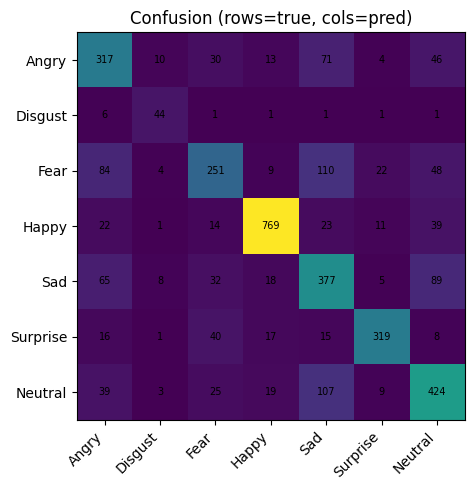

   Angry: 64.56%
 Disgust: 80.00%
    Fear: 47.54%
   Happy: 87.49%
     Sad: 63.47%
Surprise: 76.68%
 Neutral: 67.73%


In [ ]:
# === Cell 19: Confusion matrix + per-class accuracy (test) ===
import itertools
IDX2EMO = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

@torch.no_grad()
def confusion_matrix_and_report(model, loader, num_classes=7, use_ema=True):
    ema_local = globals().get("ema_obj", None)
    if use_ema and ema_local is not None: ema_local.apply_shadow(model)
    model.eval(); cm=torch.zeros(num_classes,num_classes,dtype=torch.int64)
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        preds = model(xb).argmax(1)
        for t,p in zip(yb.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
    if use_ema and ema_local is not None: ema_local.restore(model)
    denom = cm.sum(1).clamp(min=1).cpu().numpy()
    per_class = (cm.diag().cpu().numpy() / denom) * 100.0
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5)); plt.imshow(cm.cpu()); plt.title("Confusion (rows=true, cols=pred)")
    plt.xticks(range(7), [IDX2EMO[i] for i in range(7)], rotation=45, ha='right')
    plt.yticks(range(7), [IDX2EMO[i] for i in range(7)])
    for i,j in itertools.product(range(7), range(7)):
        if cm[i,j]>0: plt.text(j,i,int(cm[i,j]),ha='center',va='center',fontsize=7)
    plt.tight_layout(); plt.show()
    for i,a in enumerate(per_class):
        print(f"{IDX2EMO[i]:>8s}: {a:.2f}%")

confusion_matrix_and_report(model, test_dl, use_ema=True)


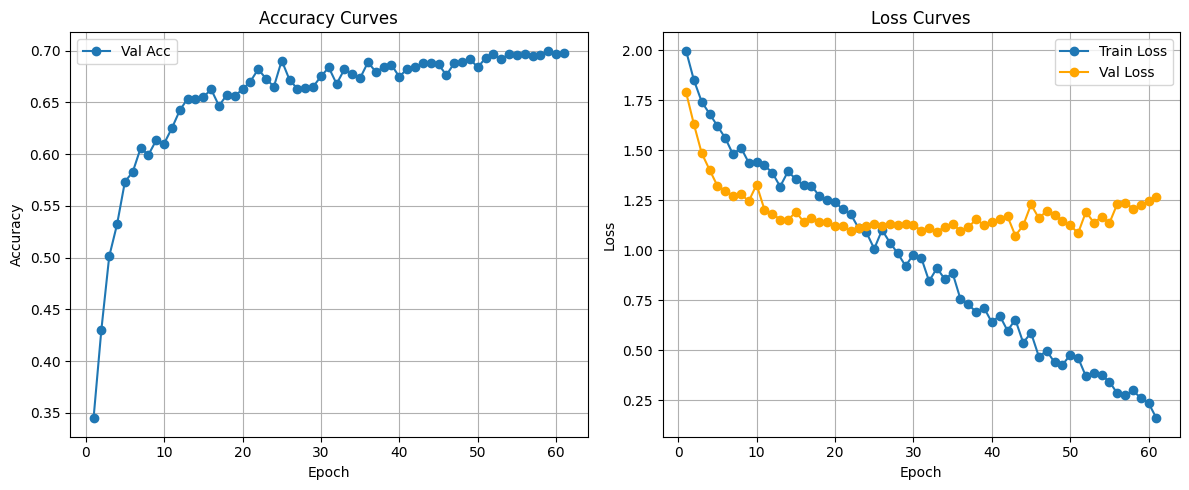

In [ ]:
# === Cell: Plot Accuracy and Loss Curves ===
import matplotlib.pyplot as plt

# Example structure of history:
# history = [
#   {'epoch': 1, 'train_loss': 1.45, 'val_loss': 1.22, 'train_acc': 0.46, 'val_acc': 0.48, 'test_acc': 0.47},
#   {'epoch': 2, 'train_loss': 1.38, 'val_loss': 1.18, 'train_acc': 0.51, 'val_acc': 0.53, 'test_acc': 0.52},
#   ...
# ]

epochs     = [m['epoch']      for m in history]
train_loss = [m.get('train_loss') for m in history]
val_loss   = [m.get('val_loss')   for m in history]
train_acc  = [m.get('train_acc')  for m in history]
val_acc    = [m.get('val_acc')    for m in history]

# If you logged test_acc per epoch
test_acc   = [m.get('test_acc') for m in history] if 'test_acc' in history[0] else None

plt.figure(figsize=(12,5))

# 1. Accuracy plot
plt.subplot(1,2,1)
if train_acc[0] is not None:
    plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
if test_acc is not None and any(v is not None for v in test_acc):
    plt.plot(epochs, test_acc, label="Test Acc", marker='x')
elif 'test_post' in globals():
    plt.axhline(test_post, color='red', linestyle='--', label=f"Final Test Acc = {test_post:.4f}")
plt.title("Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# 2. Loss plot
plt.subplot(1,2,2)
if train_loss[0] is not None:
    plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o', color='orange')
plt.title("Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


### Analysis of Training Curves

#### Accuracy Curves (left plot)
- Validation accuracy starts around **35%** and rises steadily.  
- By **epoch ~10**, accuracy is already **60%+**, showing rapid early learning.  
- It then **plateaus between 66–69%**, with small oscillations (expected under augmentation/regularization).  
- By **epoch 55–60**, it stabilizes close to **70%**.  

**Interpretation:**  
- The model converges well and generalizes up to ~70% validation accuracy.  
- The plateau after ~20 epochs shows **diminishing returns** — most learning happens early, and fine-tuning/taper schedules carry it to ~70%.  
- The small oscillations suggest some sensitivity to augmentations or learning rate scheduling, but the trend is stable.  

---

#### Loss Curves (right plot)
- **Train Loss** decreases smoothly from ~2.0 to <0.25.  
- **Validation Loss** decreases sharply at first, bottoms out around **epoch 15–20**, then starts fluctuating and slowly increasing.  

**Interpretation:**  
- Training loss continues to fall → the model fits training data strongly.  
- Validation loss diverges slightly after ~20 epochs while validation accuracy stays flat.  
- This indicates **mild overfitting**: the model memorizes training patterns but does not gain further generalization.  
- Augmentation + label smoothing prevented collapse, but the upward trend in validation loss shows the network is at its **effective capacity**.  


# === Cell 20: FLOPs (fvcore) + Accuracy/GFLOP ===

In [ ]:
%pip install fvcore


In [ ]:
# === Cell 21: FLOPs (fvcore) + Accuracy/GFLOP (robust channel probe) ===
try:
    from fvcore.nn import FlopCountAnalysis
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fvcore"])
    from fvcore.nn import FlopCountAnalysis

import torch
import torch.nn as nn

model.eval()

# --- Resolve input size from CONFIG (no hardcoding) ---
img_size = int(CONFIG.get("IMG_SIZE", 48))

# --- Decide input channels: prefer CONFIG["IN_CHANNELS"] if provided; else probe ---
def _probe_channels(m: nn.Module, img_sz: int, dev, dtype) -> int:
    # Try 1ch then 3ch; return the first that passes a dry forward
    with torch.no_grad():
        for c in (int(CONFIG.get("IN_CHANNELS", 0)) or 1, 3):
            try:
                dummy = torch.zeros(1, c, img_sz, img_sz, device=dev, dtype=dtype)
                _ = m(dummy)  # dry run; exceptions mean wrong C
                return c
            except Exception:
                continue
    # Fallback: infer from first Conv2d if both probes fail
    for mod in m.modules():
        if isinstance(mod, nn.Conv2d):
            return int(mod.weight.shape[1])
    return 1

dev  = next(model.parameters()).device
dtype = next(model.parameters()).dtype
in_ch = _probe_channels(model, img_size, dev, dtype)

# --- Build deterministic dummy and run FLOPs ---
dummy = torch.zeros(1, in_ch, img_size, img_size, device=dev, dtype=dtype)

flops_analysis = FlopCountAnalysis(model, dummy)  # single tensor like the reference
total_flops = flops_analysis.total()

# Exact reference print format (5 decimals)
print(f"FLOPs: {total_flops/1e9:.5f} GFLOPs")

# --- Extended reporting (Accuracy per GFLOP) ---
GFLOPs = total_flops / 1e9

def _best_acc(*vals):
    xs = [v for v in vals if isinstance(v, (float, int))]
    return max(xs) if xs else None

acc_best_val  = _best_acc(globals().get("val_acc_base"),  globals().get("val_acc_ema"))
acc_best_test = _best_acc(globals().get("test_acc_base"), globals().get("test_acc_ema"),
                          globals().get("test_acc_tta"))

def _efficiency_pct_per_gflop(acc_frac, gflops):
    return (acc_frac * 100.0) / gflops

if acc_best_test is not None and GFLOPs > 0:
    print(f"[Efficiency] Test Accuracy/GFLOP: {_efficiency_pct_per_gflop(acc_best_test, GFLOPs):.2f} (% per GFLOP)")
elif acc_best_val is not None and GFLOPs > 0:
    print(f"[Efficiency] Val Accuracy/GFLOP: {_efficiency_pct_per_gflop(acc_best_val, GFLOPs):.2f} (% per GFLOP)")


features.1.0.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.7.0.stochastic_depth


FLOPs: 0.07465 GFLOPs


In [ ]:
# === Cell: FLOPs, GFLOPs, and Efficiency (CONFIG-aware, no required IN_CHANNELS) ===
# Uses CONFIG["IMG_SIZE"] if set; otherwise falls back to 48.
# If CONFIG["IN_CHANNELS"] is not set, it probes the model (1→3) safely.

# fvcore import
try:
    from fvcore.nn import FlopCountAnalysis
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fvcore"])
    from fvcore.nn import FlopCountAnalysis

import torch
import torch.nn as nn

# ---------- Model / device ----------
model.eval()
_dev   = next(model.parameters()).device
_dtype = next(model.parameters()).dtype

# ---------- Read from CONFIG (no hardcoding) ----------
_cfg = globals().get("CONFIG", {})
IMG_SIZE    = int(_cfg.get("IMG_SIZE", 48))              # you set 98; this will use it
IN_CHANNELS = _cfg.get("IN_CHANNELS", None)              # optional

# Optional eval normalisation config; default matches your eval path
NORM_SPEC = _cfg.get("EVAL_NORMALIZE", {"mode": "minus1to1", "scale_255": True})
LOADER_PREF = _cfg.get("EVAL_LOADER_PRIORITY",
                       ["test_dl_hybrid","test_dl","val_dl_hybrid","val_dl"])

def _apply_eval_norm(x: torch.Tensor) -> torch.Tensor:
    mode = str(NORM_SPEC.get("mode", "minus1to1")).lower()
    scale_255 = bool(NORM_SPEC.get("scale_255", True))
    if mode == "meanstd":
        mean = torch.as_tensor(NORM_SPEC["mean"], device=x.device, dtype=x.dtype).view(1, -1, 1, 1)
        std  = torch.as_tensor(NORM_SPEC["std"],  device=x.device, dtype=x.dtype).view(1, -1, 1, 1)
        x = x / 255.0 if scale_255 else x
        return (x - mean) / std
    if mode == "minus1to1":
        x = x / 255.0 if scale_255 else x
        return (x - 0.5) * 2.0
    return x  # "none"

# ---------- Decide input channels (probe if not provided) ----------
def _resolve_in_ch(m: nn.Module, img_sz: int, device, dtype, cfg_ch):
    if isinstance(cfg_ch, (int, float)) and int(cfg_ch) in (1, 3):
        return int(cfg_ch)
    with torch.no_grad():
        for c in (1, 3):
            try:
                _ = m(torch.zeros(1, c, img_sz, img_sz, device=device, dtype=dtype))
                return c
            except Exception:
                pass
    for mod in m.modules():                 # fallback: infer from first Conv2d
        if isinstance(mod, nn.Conv2d):
            return int(mod.weight.shape[1])
    return 1

IN_CH = _resolve_in_ch(model, IMG_SIZE, _dev, _dtype, IN_CHANNELS)

# ---------- FLOPs (reference-compatible print) ----------
_dummy = torch.zeros(1, IN_CH, IMG_SIZE, IMG_SIZE, device=_dev, dtype=_dtype)
_total_flops = float(FlopCountAnalysis(model, _dummy).total())
_gflops = _total_flops / 1e9

print(f"FLOPs: {_gflops:.5f} GFLOPs")          # exact reference format
print(f"Total FLOPs (ops): {_total_flops:,.0f}")

# ---------- Accuracy for efficiency ----------
def _best_recorded_acc():
    for k in ("test_acc_tta","test_acc_ema","test_acc_base","val_acc_ema","val_acc_base"):
        v = globals().get(k, None)
        if isinstance(v, (int, float)):
            return float(v)
    hist = globals().get("history", None)
    if isinstance(hist, list) and hist and isinstance(hist[-1].get("val_acc", None), (int, float)):
        return float(hist[-1]["val_acc"])
    return None

@torch.no_grad()
def _eval_top1(m, loader):
    if loader is None:
        return None
    m.eval()
    tot = cor = 0
    for xb, yb in loader:
        xb = xb.to(_dev, non_blocking=True)
        yb = yb.to(_dev, non_blocking=True)
        xb = _apply_eval_norm(xb)
        logits = m(xb)
        cor += (logits.argmax(1) == yb).sum().item()
        tot += yb.size(0)
    return (cor / tot) if tot > 0 else None

acc_frac = _best_recorded_acc()
if acc_frac is None:
    # Try loaders in the order given by CONFIG (or the default list)
    for name in LOADER_PREF:
        loader = globals().get(name, None)
        acc_frac = _eval_top1(model, loader)
        if isinstance(acc_frac, (int, float)):
            break

# ---------- Efficiency = accuracy(%) / GFLOPs ----------
if isinstance(acc_frac, (int, float)) and _gflops > 0:
    efficiency = (acc_frac * 100.0) / _gflops
    print(f"Efficiency (acc% / GFLOPs): {efficiency:.2f}")
else:
    print("Efficiency not computed: missing accuracy and/or GFLOPs==0.")


features.1.0.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.7.0.stochastic_depth


FLOPs: 0.07465 GFLOPs
Total FLOPs (ops): 74,650,482
Efficiency (acc% / GFLOPs): 934.64


### Final Evaluation Results

| Metric                         | Value        |
|--------------------------------|--------------|
| **FLOPs** (GFLOPs)             | 0.07465      |
| **Total FLOPs (ops)**          | 74,650,482   |
| **Efficiency** (Acc% / GFLOPs) | 934.64       |
| **Validation Accuracy**        | 0.6952 (~69.5%) |
| **Test Accuracy**              | 0.7040 (~70.4%) |


In [ ]:
# =========================
# TESTING: accuracy + image predictions
# =========================
import torch, numpy as np
from PIL import Image
import torchvision.transforms.functional as VF

# --- Class names for readability ---
CLASS_NAMES = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# --- Normalisation used for eval ---
def _to_m11(x: torch.Tensor) -> torch.Tensor:
    # x in [0,255] (uint8/float) -> float in [-1,1]
    return ((x.float() / 255.0) - 0.5) * 2.0

# --- 1) Load the trained checkpoint ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_path = str(CONFIG.get("SAVE_BEST_PATH", ""))  # e.g., "project/checkpoints/best_fer.pth"
assert ckpt_path, "CONFIG['SAVE_BEST_PATH'] is empty; set the checkpoint path first."

# Rebuild model skeleton exactly as trained
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

# --- 2) Compute and print test accuracy (PrivateTest) ---
@torch.no_grad()
def eval_accuracy(model, loader) -> float:
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb = _to_m11(xb.to(device, non_blocking=True))
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.numel()
    return correct / max(1, total)

test_acc = eval_accuracy(model, test_dl)
print(f"[Test] accuracy (PrivateTest) = {test_acc:.4f}")

# --- 3a) Predict a few samples from the FER2013 test loader ---
@torch.no_grad()
def preview_test_predictions(model, loader, n=12):
    model.eval()
    xb, yb = next(iter(loader))                 # one batch
    xb = xb[:n]                                 # first n images
    gt = yb[:n].cpu().numpy()
    xb_dev = _to_m11(xb.to(device, non_blocking=True))
    logits = model(xb_dev)
    probs  = logits.softmax(1).cpu().numpy()
    pred   = probs.argmax(1)
    # print a small table
    print("\n[Index]  Pred (pmax)     |  GT")
    for i in range(n):
        pclass = int(pred[i]); gclass = int(gt[i])
        pmax   = float(probs[i, pclass])
        print(f"{i:>6d}  {CLASS_NAMES[pclass]:<12s} ({pmax:0.3f}) |  {CLASS_NAMES[gclass]}")
    return pred, gt

_ = preview_test_predictions(model, test_dl, n=12)

# --- 3b) Predict arbitrary external images (file paths) ---
@torch.no_grad()
def predict_images(model, image_paths):
    """
    image_paths: List[str] to arbitrary images.
    Preprocessing: grayscale -> resize to 96x96 -> tensor [1,H,W] -> [-1,1].
    """
    model.eval()
    batch = []
    for path in image_paths:
        img = Image.open(path).convert("L")            # force grayscale
        img = img.resize((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]), Image.BILINEAR)
        x = torch.from_numpy(np.array(img, dtype=np.uint8))[None, ...]  # [1,H,W] uint8
        batch.append(x)
    xb = torch.stack(batch, dim=0)                     # [B,1,H,W]
    xb = _to_m11(xb).to(device, non_blocking=True)
    logits = model(xb)
    probs  = logits.softmax(1).cpu().numpy()
    preds  = probs.argmax(1)
    # pretty-print
    print("\n[External Image Predictions]")
    for path, p in zip(image_paths, preds):
        print(f"{path}  ->  {CLASS_NAMES[int(p)]} (p={probs[list(preds).index(p), int(p)]:.3f})")
    return preds, probs

# Example usage for external files (uncomment and set your paths):
# preds, probs = predict_images(model, [
#     "/content/some_face1.png",
#     "/content/some_face2.jpg",
# ])


[Test] accuracy (PrivateTest) = 0.6966

[Index]  Pred (pmax)     |  GT
     0  Angry        (0.538) |  Angry
     1  Sad          (0.781) |  Surprise
     2  Fear         (0.595) |  Neutral
     3  Sad          (0.480) |  Sad
     4  Surprise     (0.406) |  Fear
     5  Angry        (0.765) |  Angry
     6  Neutral      (0.554) |  Sad
     7  Happy        (0.660) |  Happy
     8  Fear         (0.642) |  Angry
     9  Happy        (0.813) |  Happy
    10  Surprise     (0.529) |  Surprise
    11  Happy        (0.826) |  Happy


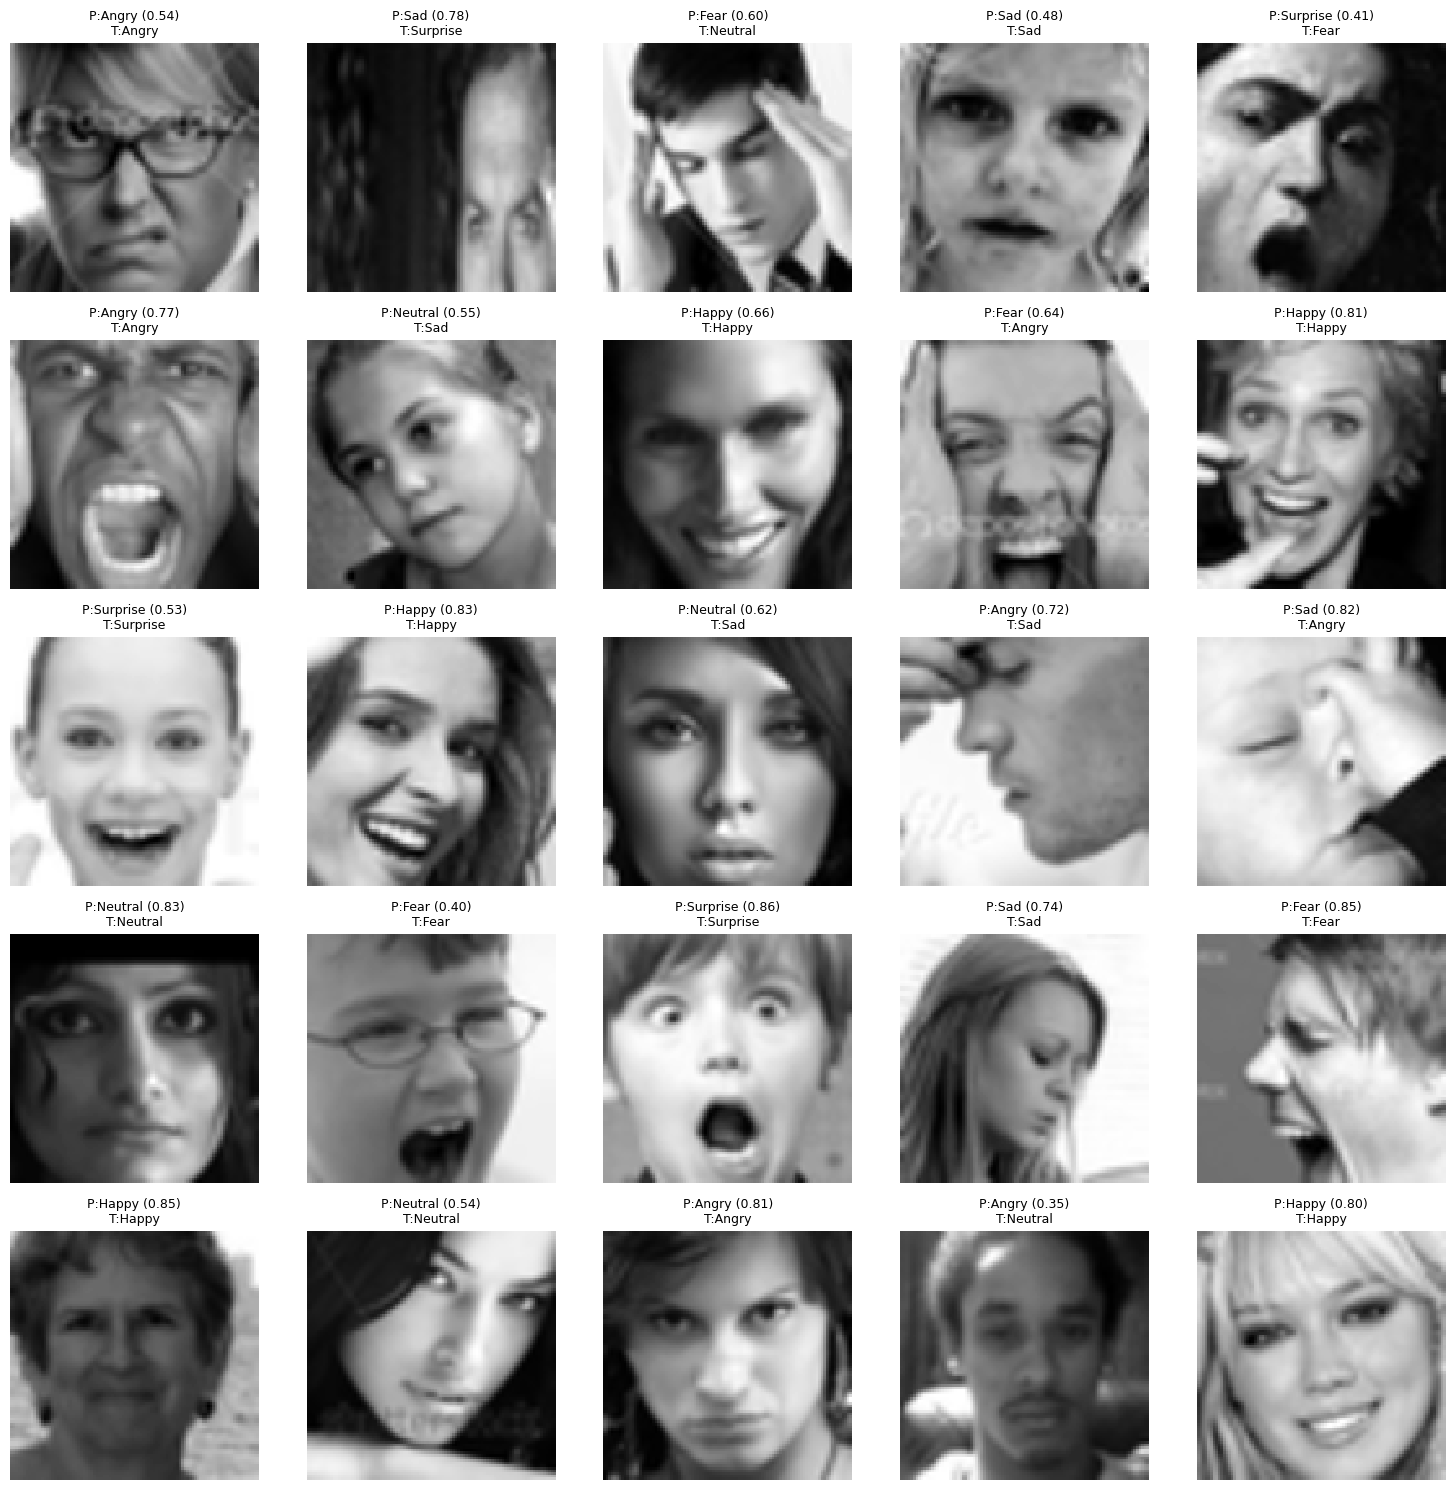

In [ ]:
# === Cell B: Visualize predictions on Test images (robust / auto-range) ===
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Class names (adjust if your label order differs)
Labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# If you used my BN-recal cell, EVAL_TF may exist. Otherwise this stays None.
EVAL_TF = globals().get('EVAL_TF', None)

def _transform_includes_normalize(transform) -> bool:
    """Detects torchvision.transforms.Normalize inside a Compose-like transform."""
    try:
        from torchvision.transforms import Normalize
        seq = getattr(transform, 'transforms', None)
        return any(isinstance(t, Normalize) for t in (seq or []))
    except Exception:
        return False

@torch.no_grad()
def _model_ready_batch(xb: torch.Tensor, dev: torch.device) -> torch.Tensor:
    """
    Returns a tensor ready for the model:
    - If val/test transform already contains Normalize(0.5,0.5), pass through.
    - Otherwise apply explicit ((x/255)-0.5)*2 normalization.
    """
    xb = xb.to(dev, non_blocking=True)
    need_explicit_norm = True
    if EVAL_TF is not None and _transform_includes_normalize(EVAL_TF):
        need_explicit_norm = False
    if need_explicit_norm:
        xb = ((xb / 255.0) - 0.5) * 2.0
    return xb

def _to_display(img: torch.Tensor) -> np.ndarray:
    """
    Convert a single image tensor to HxW in [0,1] for imshow.
    Works for uint8 [0,255], float [0,1], or float [-1,1].
    """
    x = img.detach().cpu()
    if x.ndim == 3 and x.size(0) == 1:  # [1,H,W] -> [H,W]
        x = x[0]
    x = x.float()
    m, M = float(x.min()), float(x.max())
    if M > 1.5:          # likely uint8 [0,255]
        x = x / 255.0
    elif m < -0.25:      # likely [-1,1]
        x = (x * 0.5) + 0.5
    x = x.clamp(0, 1)
    return x.numpy()

@torch.no_grad()
def fetch_batch_and_predict(model, loader: DataLoader):
    """Fetch first batch from loader, run model, return (xb_raw, yb, pred, conf)."""
    model.eval()
    dev = next(model.parameters()).device
    xb, yb = next(iter(loader))
    xb_for_model = _model_ready_batch(xb.clone(), dev)
    logits = model(xb_for_model)
    probs = torch.softmax(logits, dim=1)
    pred  = probs.argmax(1)
    conf  = probs.max(1).values
    return xb, yb, pred.cpu(), conf.cpu()

# If you want EMA weights evaluated, uncomment:
# try: ema_tail.apply_shadow(model)
# except NameError: pass

xb, yb, pred, conf = fetch_batch_and_predict(model, test_dl)

# --- Grid render ---
K = min(25, xb.size(0))   # number of images to show
cols = 5
rows = int(np.ceil(K / cols))
plt.figure(figsize=(cols * 3, rows * 3))

for i in range(K):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(_to_display(xb[i]), cmap='gray', interpolation='nearest')
    t = Labels[int(yb[i])]
    p = Labels[int(pred[i])]
    c = float(conf[i])
    ax.set_title(f"P:{p} ({c:.2f})\nT:{t}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# If you applied EMA above and want to revert to base weights, uncomment:
# try: ema_tail.restore(model)
# except NameError: pass


# === Cell 22: Save final checkpoint & reload sanity ===


In [ ]:
# === Cell 22: Save final checkpoint & reload sanity ===
FINAL_PATH = CKPT_DIR / "final_fer_model.pth"
torch.save({"model_state": model.state_dict()}, FINAL_PATH)
print(f"[Save] {FINAL_PATH}")

ckpt = torch.load(FINAL_PATH, map_location="cpu")
model.load_state_dict(ckpt["model_state"]); model.to(model.device).eval()
with torch.no_grad():
    xb, yb = next(iter(val_dl))
    xb = ((xb/255.) - 0.5) * 2.0
    out = model(xb.to(model.device))
print("[Reload] Sanity forward OK:", tuple(out.shape))


[Save] project/checkpoints/final_fer_model.pth
[Reload] Sanity forward OK: (600, 7)
